In [2]:
# MMSP PCA / biplot notebook
# import sys, plotly.io as pio
# print(sys.executable)      # should point to .../envs/maip/bin/python
# print("kaleido?" , "kaleido" in pio._valid_config["image"]["engine"]["names"])

import plotly.io as pio, IPython, nbformat
print("IPython:", IPython.__version__)
print("nbformat OK")
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---- Paths: adjust ROOT if your notebook lives elsewhere ----
ROOT = Path.cwd().resolve()

if not (ROOT / "data").exists():
    # maybe we're in notebooks/ or src/ -> try one level up
    if (ROOT.parent / "data").exists():
        ROOT = ROOT.parent
    # or two levels up (just in case)
    elif (ROOT.parent.parent / "data").exists():
        ROOT = ROOT.parent.parent
    else:
        raise FileNotFoundError(
            f"Could not find a 'data' directory from {ROOT}. "
            "Please set ROOT manually, e.g. ROOT = Path('/Users/.../ProjectMAIP')."
        )
# ROOT = Path(__file__).resolve().parents[1]  # or Path("..").resolve()

PROCD = ROOT / "data" / "01_processed"
CLUST = ROOT / "data" / "02_clusters"

SEED = 42
STRATA_BINS   = [0, 2, 4, math.inf]
STRATA_LABELS = ["Low_MM", "Mid_MM", "High_MM"]


IPython: 8.37.0
nbformat OK


In [3]:
# Load views
C = pd.read_csv(PROCD / "C_view.csv").set_index("eid")
P = pd.read_csv(PROCD / "P_view_scaled.csv").set_index("eid")

# Load MMSP cluster labels produced by run_mmsp_phase1_pam.py
mmsp_labels = pd.read_csv(CLUST / "mmsp_clusters.csv").set_index("eid")

# Align all three
ids = C.index.intersection(P.index).intersection(mmsp_labels.index)
C = C.loc[ids]
P = P.loc[ids]
mmsp_labels = mmsp_labels.loc[ids]

# Recreate strata (just to be explicit)
num_co = C["num.co"]
strata = pd.cut(
    num_co,
    bins=STRATA_BINS,
    labels=STRATA_LABELS,
    right=False,
    include_lowest=True,
).astype("category")


In [4]:
def pca_for_stratum(P_view: pd.DataFrame, ids_s, seed=SEED):
    """
    Reproduce the PCA step from run_mmsp_phase1_pam.py for a given stratum.
    Returns: (Z, pca, Xs_full)
    - Z: PCA scores (n x n_comp)
    - pca: fitted PCA object
    - Xs_full: cleaned feature matrix (after dropping near-constant cols)
    """
    Xs_full = P_view.loc[ids_s].copy()
    
    # Drop near-constant columns *within* this stratum (same threshold)
    col_std = Xs_full.std(axis=0, ddof=0)
    keep = (col_std > 1e-8)
    Xs_full = Xs_full.loc[:, keep]
    if Xs_full.shape[1] == 0:
        raise ValueError("No variable P columns left in this stratum")
    
    Xs = Xs_full.values
    
    # Exploratory PCA to hit ~80% variance, up to 20 comps
    p_explore = min(20, Xs.shape[1])
    pca_full = PCA(n_components=p_explore, svd_solver="full", random_state=seed)
    pca_full.fit(Xs)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    if np.any(cumvar >= 0.80):
        n80 = int(np.argmax(cumvar >= 0.80) + 1)
    else:
        n80 = Xs.shape[1]
    
    n_comp = min(max(2, n80), Xs.shape[1])
    
    pca = PCA(n_components=n_comp, svd_solver="full", random_state=seed)
    Z = pca.fit_transform(Xs)
    
    print(f"[{len(ids_s)} pts] components = {Z.shape[1]} "
          f"(≈{100*pca.explained_variance_ratio_.sum():.0f}% var)")
    
    return Z, pca, Xs_full


In [5]:
def plot_pca_biplot(
    Z, pca, Xs_full, clusters, title,
    n_arrows=8, figsize=(7, 6)
):
    """
    Z: PCA scores (n x n_comp)
    pca: fitted PCA model
    Xs_full: DataFrame of features used in PCA
    clusters: array-like cluster labels (same length as Z)
    """
    # Take first two PCs
    pc1, pc2 = Z[:, 0], Z[:, 1]
    labels = np.asarray(clusters)
    
    # Build a colour map for clusters
    unique = np.unique(labels)
    cmap = plt.get_cmap("tab10")
    color_map = {c: cmap(i % 10) for i, c in enumerate(unique)}
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for c in unique:
        mask = labels == c
        ax.scatter(
            pc1[mask], pc2[mask],
            s=8, alpha=0.6,
            label=str(c),
            color=color_map[c]
        )
    
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    ax.set_title(title)
    
    # ----- Loadings (arrows) -----
    # loadings: features x components
    loadings = pca.components_.T[:, :2]
    feat_names = np.array(Xs_full.columns)
    
    # Choose top |loading| features for PC1/PC2
    loading_mags = np.linalg.norm(loadings, axis=1)
    top_idx = np.argsort(loading_mags)[-n_arrows:]
    
    # Scale arrows a bit to fit into plot
    arrow_scale = 1.5 * max(pc1.std(), pc2.std())
    
    for i in top_idx:
        x, y = loadings[i] * arrow_scale
        ax.arrow(
            0, 0, x, y,
            head_width=0.1 * arrow_scale,
            head_length=0.1 * arrow_scale,
            length_includes_head=True,
            color="black",
            alpha=0.7,
        )
        ax.text(
            x * 1.05, y * 1.05,
            feat_names[i],
            fontsize=8,
            ha="center",
            va="center",
        )
    
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.axvline(0, color="grey", linewidth=0.5)
    ax.legend(
        title="Cluster",
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        fontsize=8,
    )
    fig.tight_layout()
    return fig, ax



=== Low_MM ===
[4183 pts] components = 13 (≈84% var)


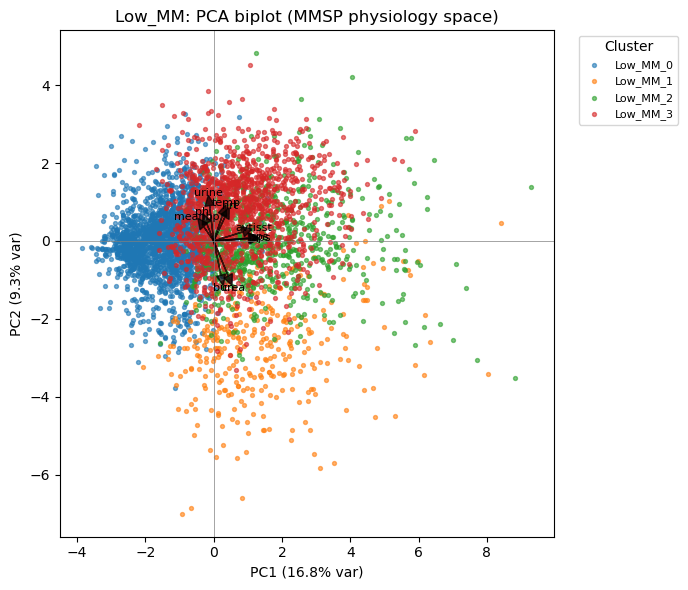


=== Mid_MM ===
[3822 pts] components = 13 (≈83% var)


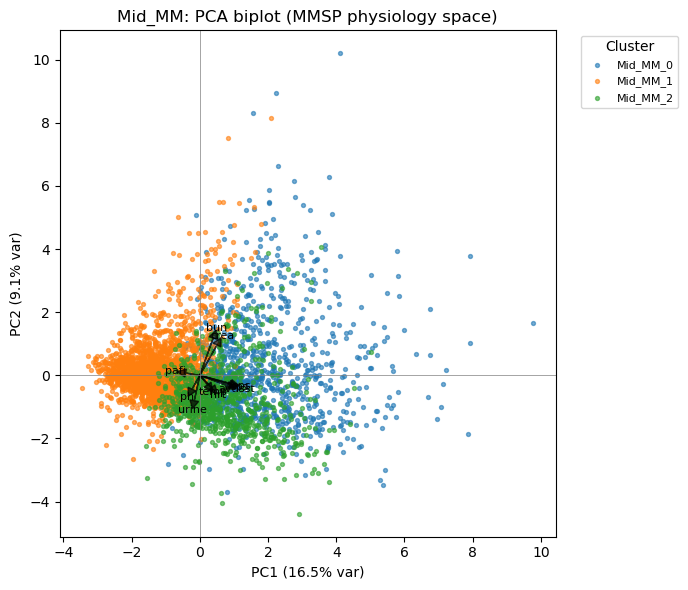


=== High_MM ===
[1100 pts] components = 12 (≈81% var)


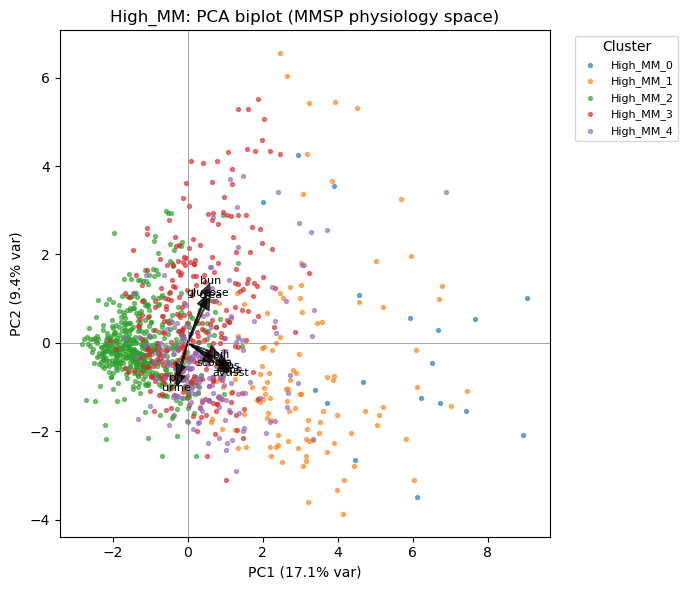

In [6]:
for s in STRATA_LABELS:
    ids_s = strata.index[strata == s]
    if len(ids_s) < 50:
        print(f"[SKIP] {s}: too few samples")
        continue
    
    print(f"\n=== {s} ===")
    Z, pca, Xs_full = pca_for_stratum(P, ids_s)
    
    # cluster labels for these eids (use 'label' or 'cluster_id')
    clusters_s = mmsp_labels.loc[ids_s, "label"]
    
    fig, ax = plot_pca_biplot(
        Z, pca, Xs_full, clusters_s,
        title=f"{s}: PCA biplot (MMSP physiology space)",
        n_arrows=10,
    )
    plt.show()
    # Optionally save
    # fig.savefig(CLUST / f"pca_biplot_{s}.png", dpi=300, bbox_inches="tight")


In [7]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

def plot_pca_biplot_3d(
    Z,
    pca,
    Xs_full,
    clusters,
    title,
    top_features=None,   # e.g. ["aps", "crea", "meanbp", "pafi"]
    n_top=4,             # if top_features is None: number of variables to label
    max_points=4000,     # subsample for clarity if n is huge
    arrow_scale=0.35,    # length of arrows relative to spread of points
    elev=22,
    azim=35,
    figsize=(8, 7),
):
    """
    3D PCA biplot (PC1, PC2, PC3) with cluster colouring and a few elongated
    loading arrows.

    Z         : (n x n_comp) PCA scores
    pca       : fitted sklearn PCA
    Xs_full   : DataFrame of P-view features used in PCA
    clusters  : array-like cluster labels (same order as Z)
    """

    Z = np.asarray(Z)
    labels = np.asarray(clusters)

    # ----- Optional subsample for readability -----
    n = Z.shape[0]
    if n > max_points:
        rng = np.random.default_rng(SEED)
        take = rng.choice(n, size=max_points, replace=False)
        Z = Z[take, :]
        labels = labels[take]

    # Use first 3 PCs
    pc1, pc2, pc3 = Z[:, 0], Z[:, 1], Z[:, 2]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")

    # Scatter by cluster (colours come from the default cycle)
    unique = np.unique(labels)
    for c in unique:
        mask = labels == c
        ax.scatter(
            pc1[mask],
            pc2[mask],
            pc3[mask],
            s=10,
            alpha=0.65,
            depthshade=False,
            label=str(c),
        )

    # Axis labels
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% var)")
    ax.set_title(title, pad=18)

    # Make the cube roughly isotropic for nicer viewing
    x_range = pc1.max() - pc1.min()
    y_range = pc2.max() - pc2.min()
    z_range = pc3.max() - pc3.min()
    max_range = max(x_range, y_range, z_range) / 2.0

    x_mid = (pc1.max() + pc1.min()) / 2.0
    y_mid = (pc2.max() + pc2.min()) / 2.0
    z_mid = (pc3.max() + pc3.min()) / 2.0

    ax.set_xlim(x_mid - max_range, x_mid + max_range)
    ax.set_ylim(y_mid - max_range, y_mid + max_range)
    ax.set_zlim(z_mid - max_range, z_mid + max_range)

    # ----- Loadings: choose a small set of key variables -----
    loadings = pca.components_.T[:, :3]  # (features x 3 PCs)
    feat_names = np.array(Xs_full.columns)

    if top_features is not None:
        mask = np.isin(feat_names, top_features)
        idx = np.where(mask)[0]
    else:
        # Choose variables with largest loading norm across PC1–PC3
        mags = np.linalg.norm(loadings, axis=1)
        idx = np.argsort(mags)[-n_top:]

    # Arrow length based on spread of scores
    scale = arrow_scale * max_range * 4.0

    for i in idx:
        vec = loadings[i] * scale
        # Arrow from origin
        ax.quiver(
            0,
            0,
            0,
            vec[0],
            vec[1],
            vec[2],
            arrow_length_ratio=0.08,
            linewidth=1.4,
        )
        # Variable label slightly beyond arrow tip
        ax.text(
            vec[0] * 1.08,
            vec[1] * 1.08,
            vec[2] * 1.08,
            feat_names[i],
            fontsize=9,
            ha="center",
            va="center",
        )

    ax.view_init(elev=elev, azim=azim)
    ax.legend(
        title="Cluster",
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.0,
        fontsize=8,
    )

    plt.tight_layout()
    return fig, ax



=== Low_MM ===
[4183 pts] components = 13 (≈84% var)


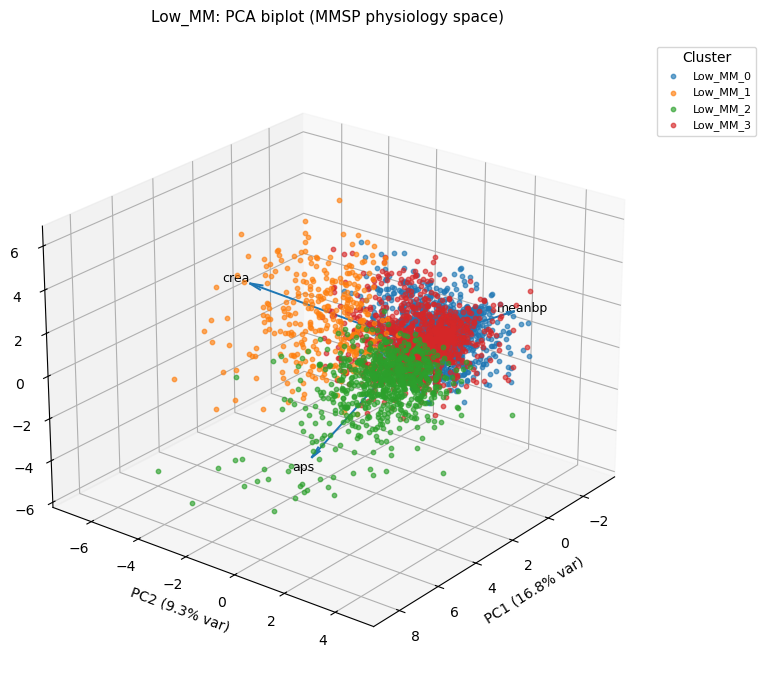


=== Mid_MM ===
[3822 pts] components = 13 (≈83% var)


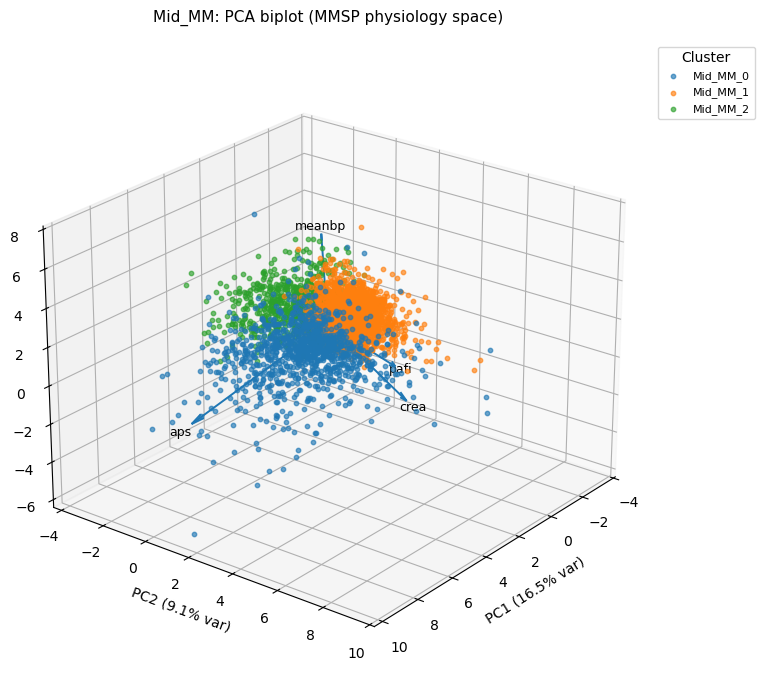


=== High_MM ===
[1100 pts] components = 12 (≈81% var)


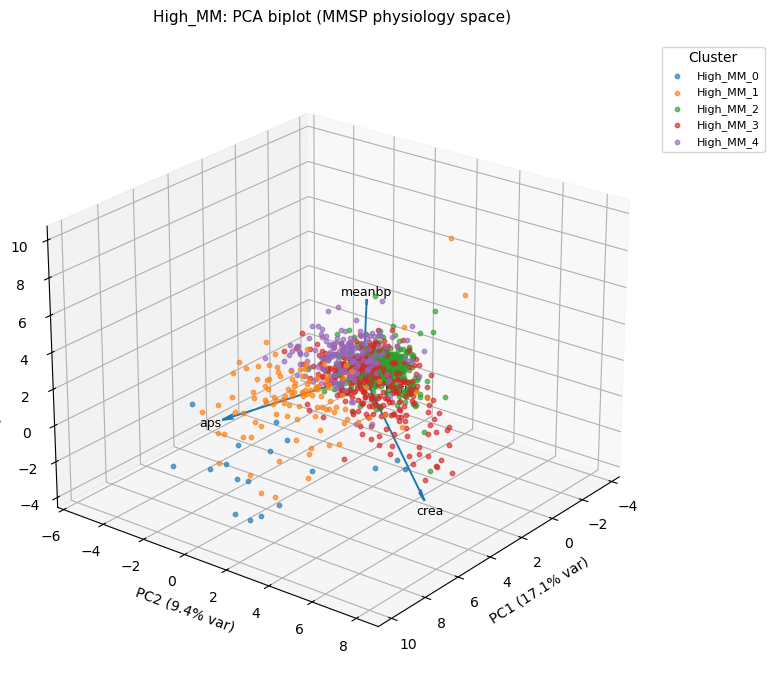

In [71]:
# Pick the key physiology variables you care about most
KEY_FEATURES = ["aps", "crea", "meanbp", "pafi"]  # adjust to your actual column names

for s in STRATA_LABELS:
    ids_s = strata.index[strata == s]
    if len(ids_s) < 50:
        print(f"[SKIP] {s}: too few samples")
        continue

    print(f"\n=== {s} ===")
    Z, pca, Xs_full = pca_for_stratum(P, ids_s)

    clusters_s = mmsp_labels.loc[ids_s, "label"]   # or "cluster_id" if you prefer

    fig, ax = plot_pca_biplot_3d(
        Z,
        pca,
        Xs_full,
        clusters_s,
        title=f"{s}: PCA biplot (MMSP physiology space)",
        top_features=KEY_FEATURES,   # or None to auto-pick top loadings
        n_top=4,                     # only used if top_features is None
        arrow_scale=0.45,            # bump up/down if you want longer/shorter arrows
        elev=24,
        azim=38,
    )
    plt.show()
    fig.savefig(CLUST / f"pca_biplot_3d_{s}.png", dpi=300, bbox_inches="tight")


Generating 3D Biplot for: Low_MM
[4183 pts] components = 13 (≈84% var)


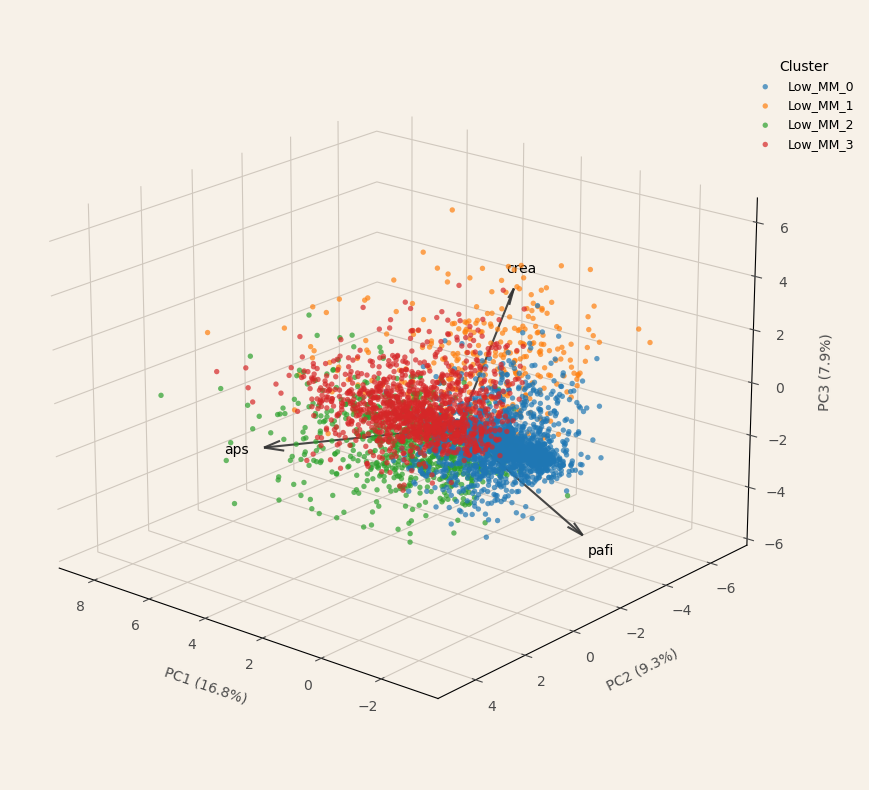

Saved to /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/pca_biplot_3d_Low_MM.png
Generating 3D Biplot for: Mid_MM
[3822 pts] components = 13 (≈83% var)


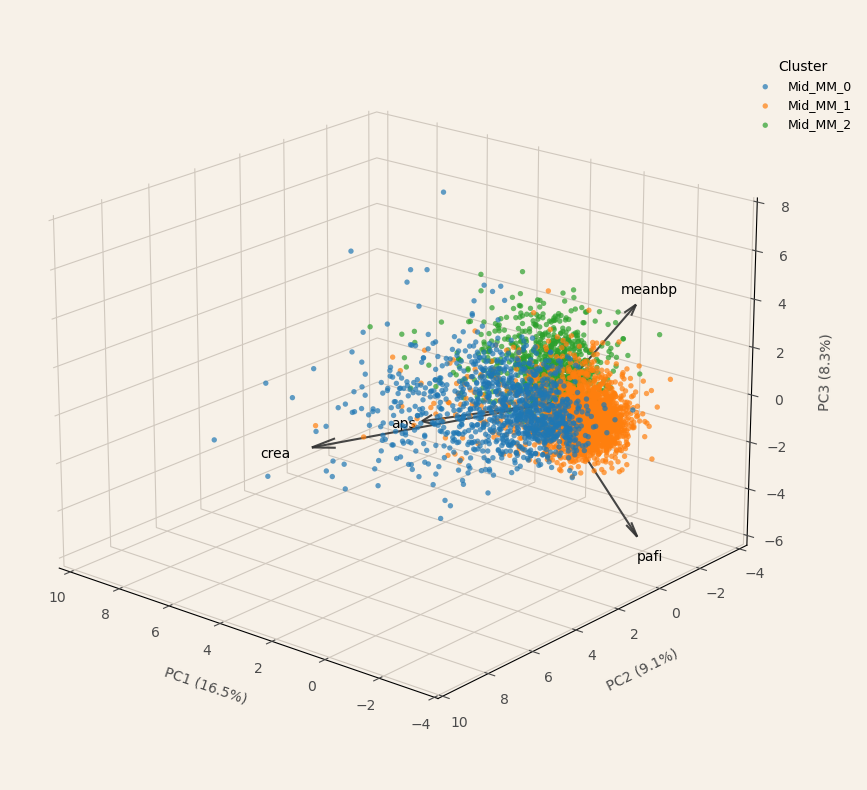

Saved to /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/pca_biplot_3d_Mid_MM.png
Generating 3D Biplot for: High_MM
[1100 pts] components = 12 (≈81% var)


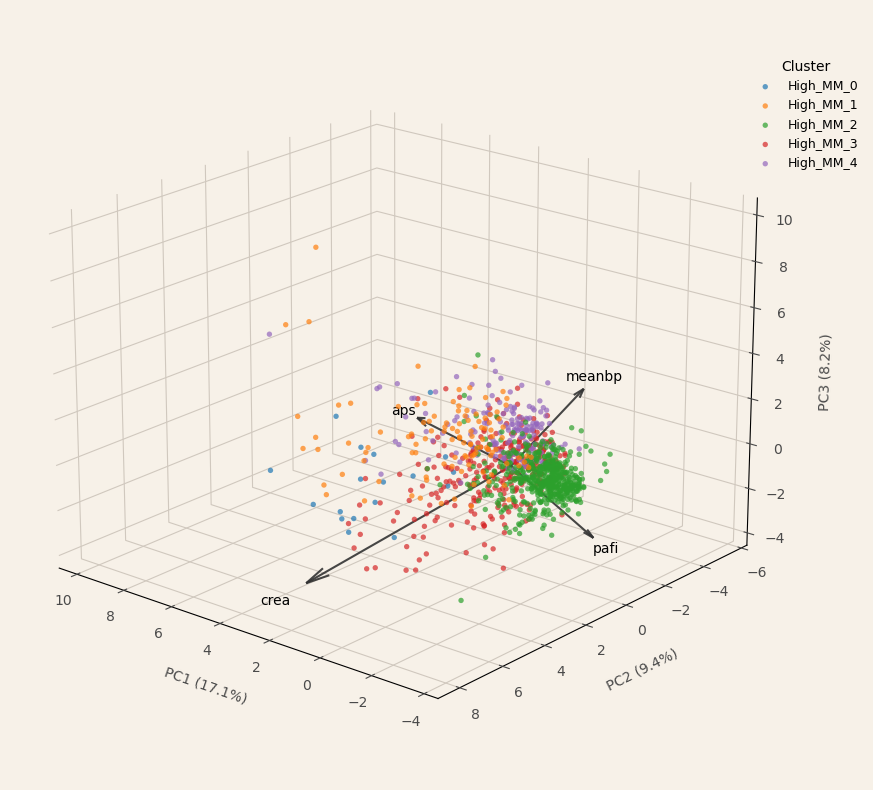

Saved to /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/pca_biplot_3d_High_MM.png


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ============================================================
# CONFIG & STYLING
# ============================================================
PORTF_BG = "#F7F1E8"
GRID_COLOR = "#d0c8be"
TEXT_COLOR = "#4a4a4a"

# Consistent color palette for clusters
PALETTE = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
           "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

def plot_pca_biplot_3d(
    Z,
    pca,
    Xs_full,
    clusters,
    top_features=None,   
    n_top=4,             
    max_points=4000,     
    arrow_scale=1.5,     # Default scale
    elev=25,
    azim=45,
    figsize=(10, 8),     
):
    """
    High-quality 3D PCA biplot with custom background and scaled arrows.
    """
    
    Z = np.asarray(Z)
    labels = np.asarray(clusters)

    # 1. Subsample
    n = Z.shape[0]
    if n > max_points:
        rng = np.random.default_rng(42)
        take = rng.choice(n, size=max_points, replace=False)
        Z = Z[take, :]
        labels = labels[take]

    pc1, pc2, pc3 = Z[:, 0], Z[:, 1], Z[:, 2]

    # 2. Figure Setup
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor(PORTF_BG)
    
    ax = fig.add_subplot(111, projection="3d")
    ax.set_facecolor(PORTF_BG)

    # 3. 3D Pane Styling
    bg_rgba = (247/255, 241/255, 232/255, 1.0)
    ax.xaxis.set_pane_color(bg_rgba)
    ax.yaxis.set_pane_color(bg_rgba)
    ax.zaxis.set_pane_color(bg_rgba)

    # Style the grid lines
    ax.xaxis._axinfo["grid"]['color'] = GRID_COLOR
    ax.yaxis._axinfo["grid"]['color'] = GRID_COLOR
    ax.zaxis._axinfo["grid"]['color'] = GRID_COLOR

    # 4. Scatter Plot
    unique_clusters = np.unique(labels)
    unique_clusters = np.sort(unique_clusters) if np.issubdtype(unique_clusters.dtype, np.number) else unique_clusters

    for i, c in enumerate(unique_clusters):
        mask = labels == c
        color = PALETTE[i % len(PALETTE)]
        ax.scatter(
            pc1[mask],
            pc2[mask],
            pc3[mask],
            s=15,             
            alpha=0.7,        
            depthshade=True,  
            c=color,
            label=str(c),
            edgecolor='none'
        )

    # 5. Axis Labels
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", labelpad=10, color=TEXT_COLOR)
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", labelpad=10, color=TEXT_COLOR)
    ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)", labelpad=10, color=TEXT_COLOR)

    ax.tick_params(axis='x', colors=TEXT_COLOR)
    ax.tick_params(axis='y', colors=TEXT_COLOR)
    ax.tick_params(axis='z', colors=TEXT_COLOR)

    # 6. Isotropic Scaling
    x_range = pc1.max() - pc1.min()
    y_range = pc2.max() - pc2.min()
    z_range = pc3.max() - pc3.min()
    max_range = max(x_range, y_range, z_range) / 2.0

    x_mid = (pc1.max() + pc1.min()) / 2.0
    y_mid = (pc2.max() + pc2.min()) / 2.0
    z_mid = (pc3.max() + pc3.min()) / 2.0

    ax.set_xlim(x_mid - max_range, x_mid + max_range)
    ax.set_ylim(y_mid - max_range, y_mid + max_range)
    ax.set_zlim(z_mid - max_range, z_mid + max_range)

    # 7. Loadings (Arrows)
    loadings = pca.components_.T[:, :3] 
    feat_names = np.array(Xs_full.columns)

    if top_features is not None:
        mask = np.isin(feat_names, top_features)
        idx = np.where(mask)[0]
    else:
        mags = np.linalg.norm(loadings, axis=1)
        idx = np.argsort(mags)[-n_top:]

    # Calculate final scale based on data spread and user input
    final_scale = arrow_scale * max_range 

    for i in idx:
        vec = loadings[i] * final_scale
        
        ax.quiver(
            0, 0, 0,        
            vec[0], vec[1], vec[2],
            color='#333333',
            arrow_length_ratio=0.1, 
            linewidth=1.5,
            alpha=0.9
        )
        
        # Text pushed 15% past arrow tip
        ax.text(
            vec[0] * 1.15,
            vec[1] * 1.15,
            vec[2] * 1.15,
            feat_names[i],
            fontsize=10,
            fontweight='medium',
            color="#000000",
            ha="center",
            va="center",
        )

    # 8. Final touches
    ax.view_init(elev=elev, azim=azim)
    
    ax.legend(
        title="Cluster",
        loc="upper left",
        bbox_to_anchor=(0.95, 0.95),
        frameon=False,       
        fontsize=9,
        title_fontsize=10,
    )

    plt.tight_layout()
    return fig, ax

# ============================================================
# EXECUTION LOOP
# ============================================================

KEY_FEATURES = ["aps", "crea", "meanbp", "pafi"] 

for s in STRATA_LABELS:
    ids_s = strata.index[strata == s]
    if len(ids_s) < 50:
        continue

    print(f"Generating 3D Biplot for: {s}")
    
    Z, pca, Xs_full = pca_for_stratum(P, ids_s)
    clusters_s = mmsp_labels.loc[ids_s, "label"]

    fig, ax = plot_pca_biplot_3d(
        Z,
        pca,
        Xs_full,
        clusters_s,
        top_features=KEY_FEATURES,
        # --- THE FIX IS HERE ---
        arrow_scale=2.0,     # Changed from 5.0 back to a reasonable size
        # -----------------------
        elev=20,            
        azim=130,           
    )
    
    out_path = CLUST / f"pca_biplot_3d_{s}.png"
    fig.savefig(
        out_path, 
        dpi=300, 
        bbox_inches="tight", 
        facecolor=fig.get_facecolor(), 
        pad_inches=0.2
    )
    
    plt.show()
    print(f"Saved to {out_path}")

In [9]:
!pip install plotly
import numpy as np
import plotly.graph_objects as go

def plot_pca_biplot_3d_plotly(
    Z,
    pca,
    Xs_full,
    clusters,
    title="3D PCA biplot",
    key_features=None,   # e.g. ["aps", "crea", "meanbp", "pafi"]
    n_top=4,             # used if key_features is None
    point_size=2.0,
    opacity=0.7,
):
    """
    Z          : PCA scores (n x >=3)
    pca        : fitted sklearn PCA
    Xs_full    : DataFrame of features used in PCA
    clusters   : array-like cluster labels (same length as Z)
    """

    Z = np.asarray(Z)
    labels = np.asarray(clusters)
    pc1, pc2, pc3 = Z[:, 0], Z[:, 1], Z[:, 2]

    fig = go.Figure()

    # ---- Scatter points by cluster ----
    for grp in np.unique(labels):
        mask = labels == grp
        fig.add_trace(go.Scatter3d(
            x=pc1[mask],
            y=pc2[mask],
            z=pc3[mask],
            mode="markers",
            name=str(grp),
            marker=dict(size=point_size, opacity=opacity),
        ))

    # ---- Loadings: pick a small set of variables ----
    loadings = pca.components_.T[:, :3]          # (features x 3 PCs)
    feat_names = np.array(Xs_full.columns)

    if key_features is not None:
        idx = [np.where(feat_names == f)[0][0]
               for f in key_features if f in feat_names]
    else:
        mags = np.linalg.norm(loadings, axis=1)
        idx = np.argsort(mags)[-n_top:]

    # Arrow length scaled to cloud size
    max_range = max(pc1.ptp(), pc2.ptp(), pc3.ptp())
    arrow_len = 0.4 * max_range

    for i in idx:
        u, v, w = loadings[i, 0], loadings[i, 1], loadings[i, 2]
        norm = np.linalg.norm([u, v, w]) or 1.0
        u_s, v_s, w_s = (u / norm) * arrow_len, (v / norm) * arrow_len, (w / norm) * arrow_len

        # Arrow shaft
        fig.add_trace(go.Scatter3d(
            x=[0, u_s], y=[0, v_s], z=[0, w_s],
            mode="lines",
            line=dict(color="rgba(60,60,60,0.9)", width=4),
            showlegend=False,
        ))

        # Arrow head
        fig.add_trace(go.Cone(
            x=[u_s], y=[v_s], z=[w_s],
            u=[u / norm], v=[v / norm], w=[w / norm],
            sizemode="absolute",
            sizeref=0.06 * arrow_len,
            anchor="tip",
            colorscale=[[0, "rgba(60,60,60,0.9)"],
                       [1, "rgba(60,60,60,0.9)"]],
            showscale=False,
        ))

        # Variable label
        fig.add_trace(go.Scatter3d(
            x=[u_s], y=[v_s], z=[w_s],
            mode="text",
            text=[feat_names[i]],
            textposition="top center",
            textfont=dict(color="black", size=11),
            showlegend=False,
        ))

    # ---- Layout: light, clean theme ----
    total_var = pca.explained_variance_ratio_[:3].sum() * 100

    fig.update_layout(
        title=f"{title} (PC1–3 explain {total_var:.1f}% var)",
        height=700,
        scene=dict(
            xaxis_title=f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
            yaxis_title=f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
            zaxis_title=f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)",
            bgcolor="white",
            xaxis=dict(
                showbackground=True,
                backgroundcolor="rgba(245,245,245,0.9)",
                gridcolor="rgba(220,220,220,0.9)",
                zerolinecolor="rgba(200,200,200,1.0)",
            ),
            yaxis=dict(
                showbackground=True,
                backgroundcolor="rgba(245,245,245,0.9)",
                gridcolor="rgba(220,220,220,0.9)",
                zerolinecolor="rgba(200,200,200,1.0)",
            ),
            zaxis=dict(
                showbackground=True,
                backgroundcolor="rgba(245,245,245,0.9)",
                gridcolor="rgba(220,220,220,0.9)",
                zerolinecolor="rgba(200,200,200,1.0)",
            ),
        ),
        paper_bgcolor="white",
        margin=dict(l=0, r=0, b=0, t=60),
        legend=dict(
            x=0.02, y=0.98,
            bgcolor="rgba(255,255,255,0.85)",
            bordercolor="rgba(0,0,0,0.1)",
            borderwidth=1,
        ),
    )

    return fig


In [15]:
import numpy as np
import plotly.graph_objects as go

def plot_pca_biplot_3d_plotly(
    Z,
    pca,
    Xs_full,
    clusters,
    title="3D PCA biplot",
    key_features=None,   # e.g. ["aps", "crea", "meanbp", "pafi"]
    n_top=4,             # used if key_features is None
    point_size=2.0,
    opacity=0.7,
):
    """
    Z          : PCA scores (n x >=3)
    pca        : fitted sklearn PCA
    Xs_full    : DataFrame of features used in PCA
    clusters   : array-like cluster labels (same length as Z)
    """

    Z = np.asarray(Z)
    labels = np.asarray(clusters)
    pc1, pc2, pc3 = Z[:, 0], Z[:, 1], Z[:, 2]

    fig = go.Figure()

    # ---- Scatter points by cluster ----
    for grp in np.unique(labels):
        mask = labels == grp
        fig.add_trace(go.Scatter3d(
            x=pc1[mask],
            y=pc2[mask],
            z=pc3[mask],
            mode="markers",
            name=str(grp),
            marker=dict(size=point_size, opacity=opacity),
        ))

    # ---- Loadings: pick a small set of variables ----
    loadings = pca.components_.T[:, :3]          # (features x 3 PCs)
    feat_names = np.array(Xs_full.columns)

    if key_features is not None:
        idx = [np.where(feat_names == f)[0][0]
               for f in key_features if f in feat_names]
    else:
        mags = np.linalg.norm(loadings, axis=1)
        idx = np.argsort(mags)[-n_top:]

    # Arrow length scaled to cloud size  (FIXED for NumPy 2.0)
    max_range = max(np.ptp(pc1), np.ptp(pc2), np.ptp(pc3))
    arrow_len = 0.4 * max_range

    for i in idx:
        u, v, w = loadings[i, 0], loadings[i, 1], loadings[i, 2]
        norm = np.linalg.norm([u, v, w]) or 1.0
        u_s, v_s, w_s = (u / norm) * arrow_len, (v / norm) * arrow_len, (w / norm) * arrow_len

        # Arrow shaft
        fig.add_trace(go.Scatter3d(
            x=[0, u_s], y=[0, v_s], z=[0, w_s],
            mode="lines",
            line=dict(color="rgba(60,60,60,0.9)", width=4),
            showlegend=False,
        ))

        # Arrow head
        fig.add_trace(go.Cone(
            x=[u_s], y=[v_s], z=[w_s],
            u=[u / norm], v=[v / norm], w=[w / norm],
            sizemode="absolute",
            sizeref=0.06 * arrow_len,
            anchor="tip",
            colorscale=[[0, "rgba(60,60,60,0.9)"],
                       [1, "rgba(60,60,60,0.9)"]],
            showscale=False,
        ))

        # Variable label
        fig.add_trace(go.Scatter3d(
            x=[u_s], y=[v_s], z=[w_s],
            mode="text",
            text=[feat_names[i]],
            textposition="top center",
            textfont=dict(color="black", size=11),
            showlegend=False,
        ))

    # ---- Layout: light, clean theme ----
    total_var = pca.explained_variance_ratio_[:3].sum() * 100

    BG = "#f7f1e8"

    fig.update_layout(
        scene=dict(
            bgcolor=BG,
            xaxis=dict(
                title="PC1",
                backgroundcolor=BG,
                showbackground=True,
                gridcolor="rgba(0,0,0,0.06)",
                zerolinecolor="rgba(0,0,0,0.18)"
            ),
            yaxis=dict(
                title="PC2",
                backgroundcolor=BG,
                showbackground=True,
                gridcolor="rgba(0,0,0,0.06)",
                zerolinecolor="rgba(0,0,0,0.18)"
            ),
            zaxis=dict(
                title="PC3",
                backgroundcolor=BG,
                showbackground=True,
                gridcolor="rgba(0,0,0,0.06)",
                zerolinecolor="rgba(0,0,0,0.18)"
            ),
        ),
        paper_bgcolor=BG,
    )

    

    return fig


In [11]:
!pip install nbformat

In [29]:
Xs_full.columns

Index(['age', 'scoma', 'avtisst', 'sps', 'aps', 'meanbp', 'wblc', 'hrt',
       'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose',
       'bun', 'urine'],
      dtype='object')

In [28]:
KEY_PHYS = ["aps", "age", "alb", "sfdm2"]

fig = plot_pca_biplot_3d_plotly(
    Z,
    pca,
    Xs_full,
    clusters_s,
    title="Low_MM: MMSP physiology PCA",
    key_features=KEY_PHYS,
    n_top=4,
    point_size=2.2,
    opacity=0.75,
)
fig.show()


In [17]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def make_strata(C: pd.DataFrame) -> pd.Series:
    if "num.co" not in C.columns:
        raise ValueError("C_view.csv must contain 'num.co'.")
    s = pd.cut(
        C["num.co"],
        bins=[0, 2, 4, float("inf")],
        labels=["Low_MM", "Mid_MM", "High_MM"],
        right=False,
        include_lowest=True,
    )
    s = s.cat.add_categories(["Unknown"]).fillna("Unknown")
    return s

def load_views():
    C = pd.read_csv(PROCD / "C_view.csv").set_index("eid")
    P = pd.read_csv(PROCD / "P_view_scaled.csv").set_index("eid")

    ids = C.index.intersection(P.index)

    Y_path = PROCD / "Y_validation.csv"
    if Y_path.exists():
        Y_raw = pd.read_csv(Y_path)
        if "eid" in Y_raw.columns:
            Y = Y_raw.set_index("eid").loc[ids]
        else:
            print("[WARN] Y_validation.csv has no 'eid'; proceeding without Y for now.")
            Y = pd.DataFrame(index=ids)
    else:
        Y = pd.DataFrame(index=ids)

    return C.loc[ids], P.loc[ids], Y

# Load views + strata + MMSP cluster labels
C, P, Y = load_views()
strata = make_strata(C)  # Low_MM / Mid_MM / High_MM

mmsp = pd.read_csv(CLUST / "mmsp_clusters.csv").set_index("eid")

KEY_PHYS = ["aps", "crea", "meanbp", "pafi"]  # adjust if any names differ

for s in STRATA_LABELS:   # ["Low_MM", "Mid_MM", "High_MM"]
    ids_s = strata.index[strata == s]
    ids_s = ids_s.intersection(mmsp.index)

    print(f"\n=== {s} ===")
    print(f"[{len(ids_s)} pts]")

    # Build physiology matrix for this stratum
    Xs_full = P.loc[ids_s].copy()

    # Drop near-constant columns (same logic as run_mmsp_phase1_pam.py)
    col_std = Xs_full.std(axis=0, ddof=0)
    keep = (col_std > 1e-8)
    Xs_full = Xs_full.loc[:, keep]

    if Xs_full.shape[1] < 3:
        print(f"[WARN] {s}: <3 features left after filtering; skipping 3D biplot.")
        continue

    Xs = Xs_full.values

    # PCA: choose enough comps to hit ~80% var, minimum 3 comps (for 3D plot)
    p_explore = min(20, Xs.shape[1])
    pca_full = PCA(n_components=p_explore, svd_solver="full", random_state=SEED)
    pca_full.fit(Xs)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n80 = int(np.argmax(cumvar >= 0.80) + 1) if np.any(cumvar >= 0.80) else Xs.shape[1]
    n_comp = min(max(3, n80), Xs.shape[1])

    pca = PCA(n_components=n_comp, svd_solver="full", random_state=SEED)
    Z   = pca.fit_transform(Xs)
    pct = 100.0 * float(pca.explained_variance_ratio_.sum())
    print(f"[PCA] components = {Z.shape[1]} (≈{pct:.0f}% var)")

    # MMSP cluster labels for this stratum
    clusters_s = mmsp.loc[ids_s, "label"].values  # or "cluster_id" if you prefer

    # 3D biplot
    fig = plot_pca_biplot_3d_plotly(
        Z,
        pca,
        Xs_full,
        clusters_s,
        title=f"{s}: MMSP physiology PCA",
        key_features=KEY_PHYS,
        n_top=4,
        point_size=2.2,
        opacity=0.75,
    )
    fig.show()          # or fig.write_html(OUTD / f"pca_biplot_{s}.html")



=== Low_MM ===
[4183 pts]
[PCA] components = 13 (≈84% var)



=== Mid_MM ===
[3822 pts]
[PCA] components = 13 (≈83% var)



=== High_MM ===
[1100 pts]
[PCA] components = 12 (≈81% var)


In [18]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.io as pio

C, P, Y = load_views()
strata = make_strata(C)
mmsp = pd.read_csv(CLUST / "mmsp_clusters.csv").set_index("eid")

KEY_PHYS = ["aps", "crea", "meanbp", "pafi"]

for s in STRATA_LABELS:   # ["Low_MM", "Mid_MM", "High_MM"]
    ids_s = strata.index[strata == s]
    ids_s = ids_s.intersection(mmsp.index)

    print(f"\n=== {s} ===")
    print(f"[{len(ids_s)} pts]")

    Xs_full = P.loc[ids_s].copy()
    col_std = Xs_full.std(axis=0, ddof=0)
    keep = (col_std > 1e-8)
    Xs_full = Xs_full.loc[:, keep]

    if Xs_full.shape[1] < 3:
        print(f"[WARN] {s}: <3 features left after filtering; skipping 3D biplot.")
        continue

    Xs = Xs_full.values

    p_explore = min(20, Xs.shape[1])
    pca_full = PCA(n_components=p_explore, svd_solver="full", random_state=SEED)
    pca_full.fit(Xs)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n80 = int(np.argmax(cumvar >= 0.80) + 1) if np.any(cumvar >= 0.80) else Xs.shape[1]
    n_comp = min(max(3, n80), Xs.shape[1])

    pca = PCA(n_components=n_comp, svd_solver="full", random_state=SEED)
    Z   = pca.fit_transform(Xs)

    clusters_s = mmsp.loc[ids_s, "label"].values

    fig = plot_pca_biplot_3d_plotly(
        Z,
        pca,
        Xs_full,
        clusters_s,
        title=f"{s}: MMSP physiology PCA",
        key_features=KEY_PHYS,
        n_top=4,
        point_size=2.2,
        opacity=0.75,
    )

    # save PNG for the portfolio (adjust paths to your repo structure)
    out_path = CLUST / f"pca_biplot_{s}.png"
    fig.write_image(out_path, width=900, height=700, scale=3)
    print(f"[Saved] {out_path}")



=== Low_MM ===
[4183 pts]
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/pca_biplot_Low_MM.png

=== Mid_MM ===
[3822 pts]
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/pca_biplot_Mid_MM.png

=== High_MM ===
[1100 pts]
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/pca_biplot_High_MM.png


In [ ]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

PORTF_BG = "#f7f1e8"

def plot_pca_biplot_2d_plotly(
    Z,
    pca,
    X_df,
    clusters,
    title="PCA biplot",
    key_features=None,
    n_top=4,
    point_size=3.0,
    opacity=0.7,
    bg=PORTF_BG,
):
    """
    2D PCA biplot (PC1 vs PC2) with arrows for selected features.

    Parameters
    ----------
    Z : np.ndarray
        PCA scores matrix (n_samples x n_components) from `pca.transform(...)`.
    pca : sklearn.decomposition.PCA
        Fitted PCA object.
    X_df : pd.DataFrame
        Original feature matrix used to fit the PCA (columns = feature names).
    clusters : array-like
        Cluster labels for colouring points (e.g. mmsp labels).
    key_features : list[str] or None
        If provided, only draw arrows for these feature names (if present).
        Otherwise, choose the `n_top` features with largest loading magnitude
        in the (PC1, PC2) plane.
    """

    pc1 = Z[:, 0]
    pc2 = Z[:, 1]

    # Base scatter
    fig = px.scatter(
        x=pc1,
        y=pc2,
        color=pd.Series(clusters, name="Cluster").astype(str),
        labels={"x": "PC1", "y": "PC2", "color": "Cluster"},
        title=title,
        template="none",
    )
    fig.update_traces(
        marker=dict(size=point_size, opacity=opacity, line=dict(width=0))
    )

    # --- Loadings for PC1 / PC2 ---
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    feature_names = np.array(X_df.columns)

    # Choose which features to draw
    if key_features:
        idx = [np.where(feature_names == f)[0][0]
               for f in key_features if f in feature_names]
    else:
        # top n_top by loading magnitude in (PC1, PC2)
        mags = np.sqrt(loadings[:, 0] ** 2 + loadings[:, 1] ** 2)
        idx = np.argsort(mags)[-n_top:]

    if len(idx) == 0:
        # no arrows to draw
        return fig

    # Scale arrows relative to point cloud spread
    max_range = np.max(np.ptp(Z[:, :2], axis=0))  # range of PC1 & PC2
    scale = 0.5 * max_range  # tweak factor if you want longer/shorter arrows

    for i in idx:
        lx, ly = loadings[i, 0], loadings[i, 1]
        x_end, y_end = lx * scale, ly * scale
        feat = feature_names[i]

        # Arrow from origin
        fig.add_shape(
            type="line",
            x0=0, y0=0,
            x1=x_end, y1=y_end,
            xref="x", yref="y",
            line=dict(color="#5a5245", width=2),
        )

        # Feature label near arrow tip
        fig.add_annotation(
            x=x_end,
            y=y_end,
            text=feat,
            showarrow=False,
            xanchor="center",
            yanchor="bottom",
            font=dict(color="#5a5245", size=13),
            yshift=4,
        )

    # Layout styling to match portfolio theme
    fig.update_layout(
        width = 700, # push here
        height = 550, # and here
        plot_bgcolor=bg,
        paper_bgcolor=bg,
        title_font=dict(color="#3a3126", size=18),
        legend=dict(
            font=dict(color="#3a3126", size=11),
            bgcolor="rgba(247,241,232,0.8)",
            bordercolor="rgba(0,0,0,0.05)",
            borderwidth=1,
        ),
        xaxis=dict(
            title="PC1",
            zeroline=True,
            zerolinecolor="rgba(0,0,0,0.25)",
            showgrid=True,
            gridcolor="rgba(0,0,0,0.06)",
            linecolor="rgba(0,0,0,0.25)",
            showline=True,  # Keeps the bottom axis line
            mirror=False,   # REMOVES top/right frame border
        ),
        yaxis=dict(
            title="PC2",
            zeroline=True,
            zerolinecolor="rgba(0,0,0,0.25)",
            showgrid=True,
            gridcolor="rgba(0,0,0,0.06)",
            linecolor="rgba(0,0,0,0.25)",
            showline=True,  # Keeps the bottom axis line
            mirror=False,   # REMOVES top/right frame border
        ),
        margin=dict(l=25, r=20, t=40, b=30),
    )

    return fig


In [48]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA

# assume load_views, make_strata, STRATA_LABELS, SEED etc already defined
C, P, Y = load_views()
strata = make_strata(C)

CLUST = ROOT / "data" / "02_clusters"   # or whatever you use
mmsp = pd.read_csv(CLUST / "mmsp_clusters.csv").set_index("eid")

KEY_PHYS = ["aps", "alb", "age", "pafi"]

for s in STRATA_LABELS:   # ["Low_MM", "Mid_MM", "High_MM"]
    ids_s = strata.index[strata == s]
    ids_s = ids_s.intersection(mmsp.index)

    print(f"\n=== {s} ===")
    print(f"[{len(ids_s)} pts]")

    Xs_full = P.loc[ids_s].copy()

    # Drop near-constant physio columns within stratum
    col_std = Xs_full.std(axis=0, ddof=0)
    keep = (col_std > 1e-8)
    Xs_full = Xs_full.loc[:, keep]

    if Xs_full.shape[1] < 3:
        print(f"[WARN] {s}: <3 features left after filtering; skipping PCA biplot.")
        continue

    Xs = Xs_full.values

    # PCA as in run_mmsp_phase1_pam.py
    p_explore = min(20, Xs.shape[1])
    pca_full = PCA(n_components=p_explore, svd_solver="full", random_state=SEED)
    pca_full.fit(Xs)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n80 = int(np.argmax(cumvar >= 0.80) + 1) if np.any(cumvar >= 0.80) else Xs.shape[1]
    n_comp = min(max(3, n80), Xs.shape[1])

    pca = PCA(n_components=n_comp, svd_solver="full", random_state=SEED)
    Z   = pca.fit_transform(Xs)

    print(f"[{s}] components = {Z.shape[1]} (≈{100*pca.explained_variance_ratio_.sum():.0f}% var)")

    clusters_s = mmsp.loc[ids_s, "label"].values

    fig2d = plot_pca_biplot_2d_plotly(
        Z,
        pca,
        Xs_full,
        clusters_s,
        title=None,
        key_features=KEY_PHYS,   # will only draw arrows for these if present
        n_top=4,
        point_size=3.5,
        opacity=0.75,
    )

    out_path = CLUST / f"pca_biplot_2d_{s}.png"
    fig2d.write_image(out_path, width=700, height=550, scale=2)
    print(f"[Saved] {out_path}")



=== Low_MM ===
[4183 pts]
[Low_MM] components = 13 (≈84% var)
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/pca_biplot_2d_Low_MM.png

=== Mid_MM ===
[3822 pts]
[Mid_MM] components = 13 (≈83% var)
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/pca_biplot_2d_Mid_MM.png

=== High_MM ===
[1100 pts]
[High_MM] components = 12 (≈81% var)
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/pca_biplot_2d_High_MM.png


Loaded variable dictionary from /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/glossary_used.json
Variables used in heatmaps: ['diabetes', 'dementia', 'ca', 'dzgroup_arf_mosf', 'dzgroup_chf', 'dzgroup_copd', 'dzgroup_lung_cancer', 'dzgroup_mosf_malig', 'dzgroup_coma', 'dzgroup_cirrhosis', 'dzgroup_colon_cancer', 'aps', 'age']


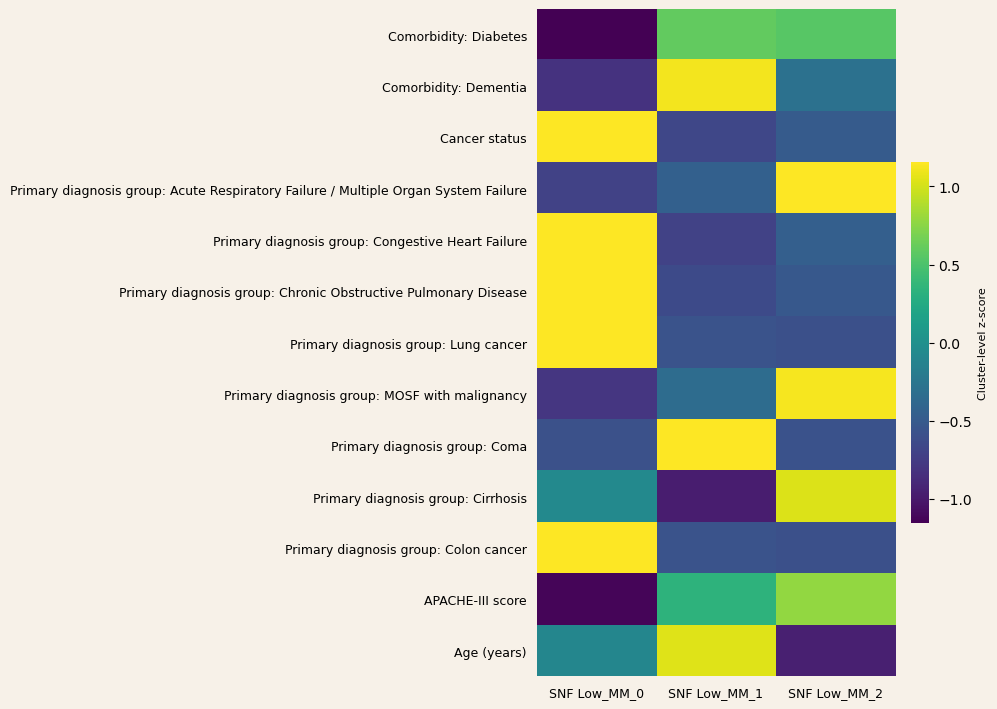

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/heatmap_snf_Low_MM.png


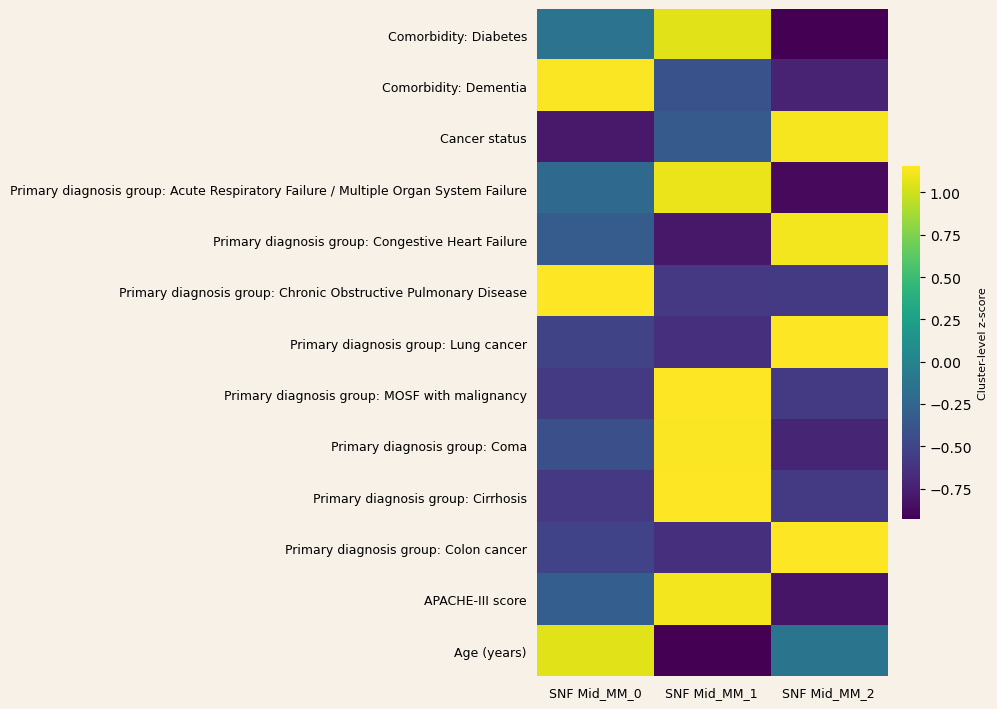

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/heatmap_snf_Mid_MM.png


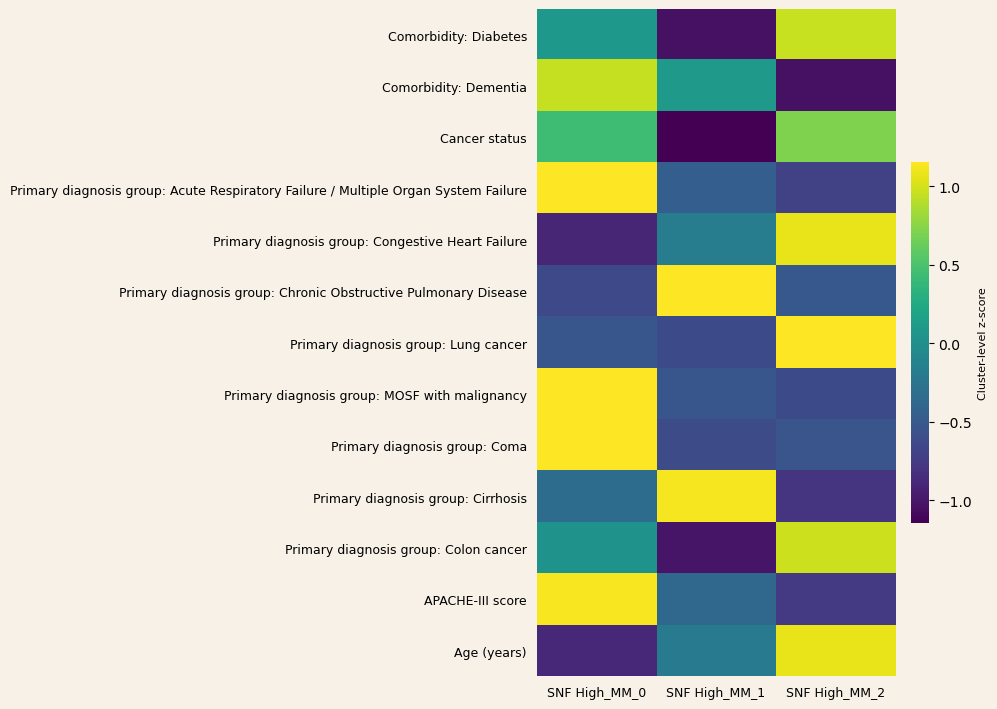

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/heatmap_snf_High_MM.png


In [87]:
# ============================================================
# Heatmaps: SNF-lite cluster profiles by stratum (Primo Layout)
# ============================================================
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. CONFIGURATION ---
PORTF_BG = "#F7F1E8"
ROOT = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP")

PROC = ROOT / "data" / "01_processed"
CLUS = ROOT / "data" / "02_clusters"
OUT_FIG = ROOT / "reports" / "figures"
OUT_FIG.mkdir(parents=True, exist_ok=True)

# --- 2. LOAD DATA ---
C = pd.read_csv(PROC / "C_view.csv")
P = pd.read_csv(PROC / "P_view_scaled.csv")
S = pd.read_csv(PROC / "S_view.csv")
Y = pd.read_csv(PROC / "Y_validation.csv")
L_mmsp = pd.read_csv(CLUS / "mmsp_clusters.csv")
L_snf  = pd.read_csv(CLUS / "snf_clusters_all.csv")

# Merge logic
df = (
    C.merge(P, on="eid")
     .merge(S, on="eid")
     .merge(Y, on="eid")
     .merge(L_mmsp[["eid","stratum","label"]].rename(columns={"label":"label_mmsp"}),
            on="eid", how="inner")
)

merge_keys = ["eid"] + (["stratum"] if "stratum" in L_snf.columns else [])
df = df.merge(
    L_snf[merge_keys + ["cluster_id","label"]]
        .rename(columns={"cluster_id":"cluster_id_snf","label":"label_snf"}),
    on=merge_keys,
    how="inner",
)

# --- 3. VARIABLE DICTIONARY & DISPLAY ---
var_dict = {}
try:
    VAR_DICT_PATH = ROOT / "reports" / "glossary_used.json"
    with open(VAR_DICT_PATH, "r") as f:
        var_dict = json.load(f)
    print("Loaded variable dictionary from", VAR_DICT_PATH)
except FileNotFoundError:
    print("[WARN] glossary_used.json not found - using raw column names.")

def get_display_name(col: str) -> str:
    """Pretty label for a variable."""
    info = var_dict.get(col)
    if isinstance(info, dict):
        name = info.get("display_name")
        units = info.get("units")
        if name and units:
            return f"{name} ({units})"
        elif name:
            return name
    elif isinstance(info, str):
        return info.split("(")[0].rstrip(". ")
    return col

# Variables to show in the heatmaps
cond_vars = [
    "diabetes", "dementia", "ca",
    "dzgroup_arf_mosf", "dzgroup_chf", "dzgroup_copd",
    "dzgroup_lung_cancer", "dzgroup_mosf_malig", "dzgroup_coma",
    "dzgroup_cirrhosis", "dzgroup_colon_cancer",
    "aps", "age"
]
# Filter to existing columns
cond_vars = [c for c in cond_vars if c in df.columns]
print("Variables used in heatmaps:", cond_vars)

strata_order = ["Low_MM", "Mid_MM", "High_MM"]
stratum_col = "stratum"
snf_col  = "label_snf"

# --- 4. PLOTTING LOOP ---
for stratum in strata_order:
    g = df[df[stratum_col] == stratum].copy()
    g = g.dropna(subset=[snf_col])

    if g.empty:
        print(f"[WARN] No data for stratum {stratum}, skipping.")
        continue

    # Calculate cluster means & Z-scores
    cluster_means = g.groupby(snf_col)[cond_vars].mean()
    means = cluster_means.mean(axis=0)
    stds = cluster_means.std(axis=0).replace(0, np.nan)
    z = (cluster_means - means) / stds

    # Prepare matrix: variables (rows) x clusters (columns)
    heat_data = z.T
    row_labels = [get_display_name(c) for c in heat_data.index]
    col_labels = [f"SNF {c}" for c in heat_data.columns]

    # --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(10, 0.4 * len(row_labels) + 2))
    
    # Background
    fig.patch.set_facecolor(PORTF_BG)
    ax.set_facecolor(PORTF_BG)

    im = ax.imshow(heat_data.values, aspect="auto", cmap="viridis")

    # Axes styling
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=0, fontsize=9)
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=9)
    
    # Remove ticks/spines for cleaner look
    ax.tick_params(top=False, bottom=False, left=False, right=False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Cluster-level z-score", fontsize=8)
    cbar.outline.set_visible(False) # No border on colorbar

    plt.tight_layout()
    
    # SAVE
    out_path = OUT_FIG / f"heatmap_snf_{stratum}.png"
    fig.savefig(out_path, dpi=300, facecolor=PORTF_BG, bbox_inches="tight")
    plt.show()
    
    print(f"[Saved] {out_path}")

In [37]:
VAR_DICT_PATH

PosixPath('/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/tables/glossary_used.json')

/var/folders/yz/2q6jdys179d8sg7y3qh6d8740000gn/T/ipykernel_66466/1426316025.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/var/folders/yz/2q6jdys179d8sg7y3qh6d8740000gn/T/ipykernel_66466/1426316025.py:50: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/var/folders/yz/2q6jdys179d8sg7y3qh6d8740000gn/T/ipykernel_66466/1426316025.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/var/folders/yz/2q6jdys179d8sg7y3qh6d8740000gn/T/ipykernel_66466/1426316025.py:50: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/var/folders/yz/2q6jdys179d8sg7y3qh6d8740000gn/T/ipykernel_66466/1426316025.py:49: Futur

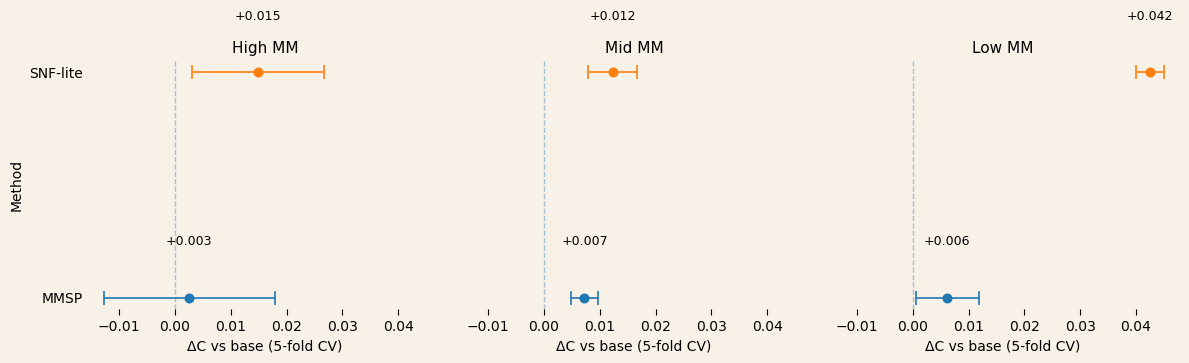

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

ROOT = Path("..").resolve()
cv_summary = pd.read_csv(ROOT / "reports" / "tables" / "table_external_prognostic_cv_summary.csv")

plot_df = cv_summary[cv_summary["Method"].isin(["MMSP", "SNF-lite"])].copy()

strata_order = ["High_MM", "Mid_MM", "Low_MM"]
strata_titles = {
    "High_MM": "High MM",
    "Mid_MM": "Mid MM",
    "Low_MM": "Low MM",
}
method_order = ["MMSP", "SNF-lite"]

# --- Figure + aesthetic setup ---
bg = "#F7F1E8"
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
})

fig, axes = plt.subplots(1, 3, figsize=(12, 3.8), sharex=True, sharey=True)
fig.patch.set_facecolor(bg)

for ax, stratum in zip(axes, strata_order):
    d = plot_df[plot_df["Stratum"] == stratum]

    ax.set_facecolor(bg)

    # Remove box / spines
    for side in ["top", "right", "left", "bottom"]:
        ax.spines[side].set_visible(False)

    # Light vertical line at ΔC = 0 (base)
    ax.axvline(0.0, linestyle="--", linewidth=1, alpha=0.4)

    # Y positions
    y_positions = np.arange(len(method_order))

    for y, method in zip(y_positions, method_order):
        row = d[d["Method"] == method]
        if row.empty:
            continue
        delta = float(row["Delta_C_mean"])
        sd    = float(row["Delta_C_sd"])

        ax.errorbar(
            x=delta,
            y=y,
            xerr=sd,
            fmt="o",
            capsize=5,
            elinewidth=1.2,
            markeredgewidth=1.2,
        )
        ax.text(
            delta,
            y + 0.22,
            f"{delta:+.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_yticks(y_positions)
    ax.set_yticklabels(method_order)
    ax.tick_params(axis="y", length=0)   # hide tick marks
    ax.tick_params(axis="x", length=4)

    ax.set_title(strata_titles[stratum])

axes[0].set_ylabel("Method")
for ax in axes:
    ax.set_xlabel("ΔC vs base (5-fold CV)")

# fig.suptitle("Cross-validated ΔC versus base clinical model by multimorbidity stratum",
#              y=1.03, fontsize=12)
fig.tight_layout()
plt.show()


Variables used in MMSP heatmaps: ['diabetes', 'dementia', 'ca', 'dzgroup_arf_mosf', 'dzgroup_chf', 'dzgroup_copd', 'dzgroup_lung_cancer', 'dzgroup_mosf_malig', 'dzgroup_coma', 'dzgroup_cirrhosis', 'dzgroup_colon_cancer', 'aps', 'age']


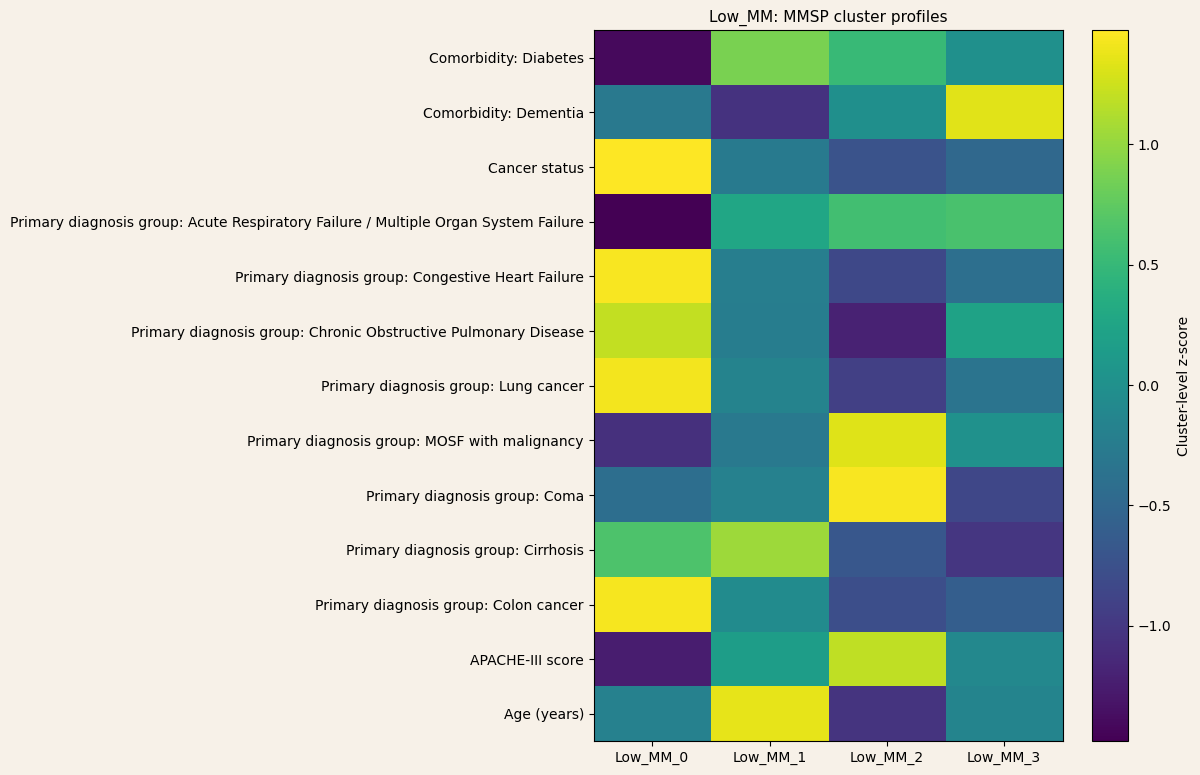

Saved: /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/heatmap_mmsp_Low_MM.png


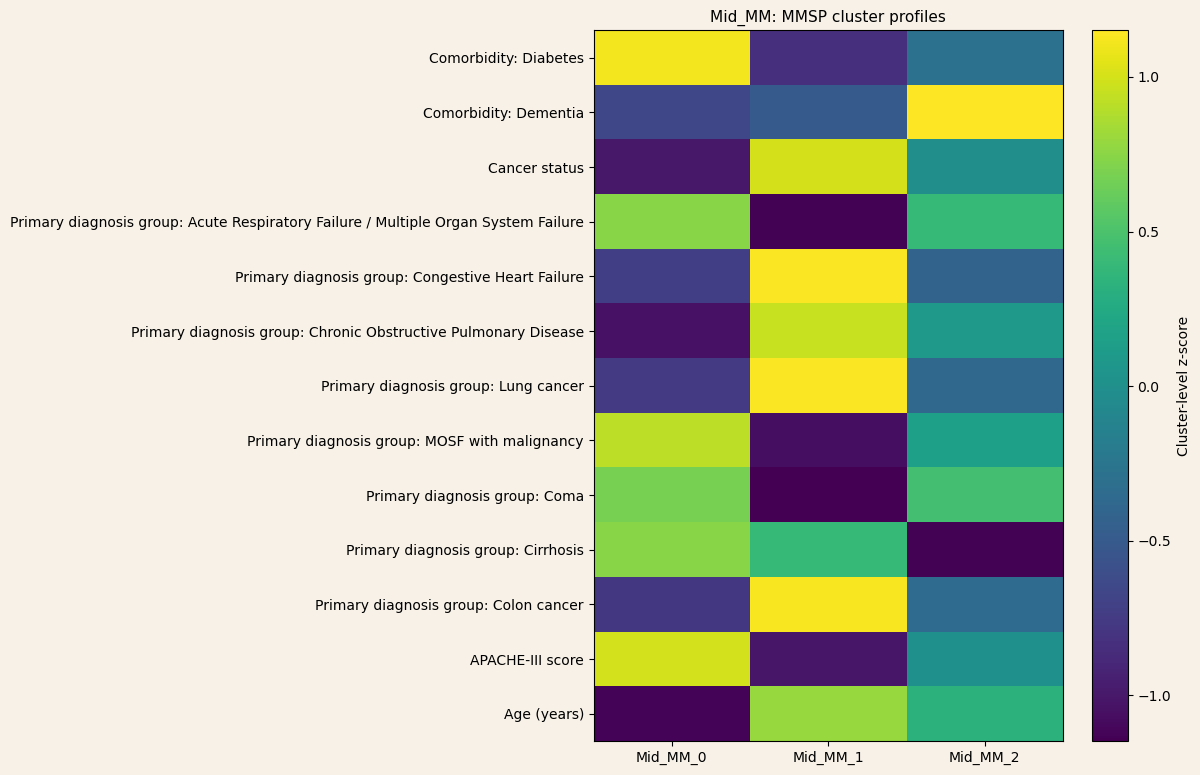

Saved: /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/heatmap_mmsp_Mid_MM.png


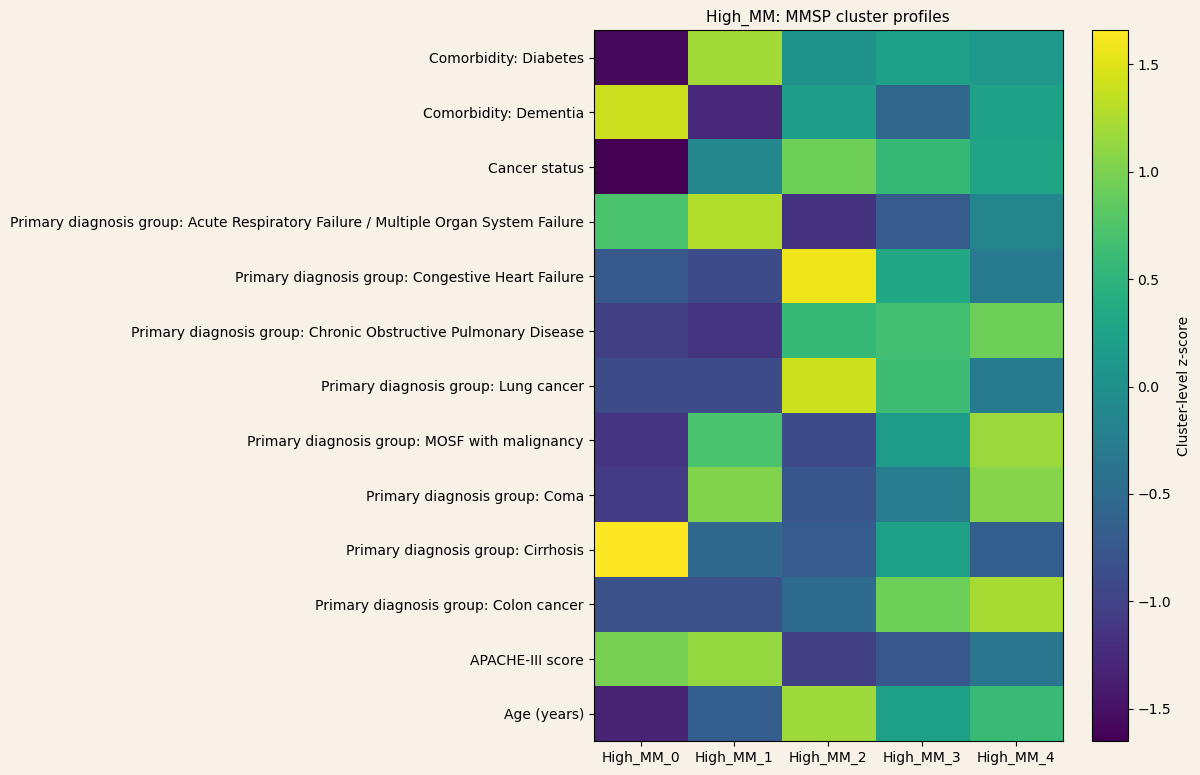

Saved: /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/heatmap_mmsp_High_MM.png


In [51]:
# ============================================================
# Heatmaps: MMSP cluster profiles by stratum
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import json

PORTF_BG = "#F7F1E8"

# --- assume df, stratum_col, mmsp_col, var_dict are already defined as in your cell ---

def get_display_name(col: str) -> str:
    """Pretty label for a variable, using display_name/units from the JSON if available."""
    info = var_dict.get(col, None)
    if isinstance(info, dict):
        name = info.get("display_name")
        units = info.get("units")
        if name and units:
            return f"{name} ({units})"
        elif name:
            return name
    elif isinstance(info, str):
        s = info.split("(")[0]
        return s.rstrip(". ")
    return col

# Condition / physiology variables to show in the heatmaps
cond_vars = [
    "diabetes",
    "dementia",
    "ca",
    "dzgroup_arf_mosf",
    "dzgroup_chf",
    "dzgroup_copd",
    "dzgroup_lung_cancer",
    "dzgroup_mosf_malig",
    "dzgroup_coma",
    "dzgroup_cirrhosis",
    "dzgroup_colon_cancer",
    "aps",
    "age",
]

# Keep only variables that actually exist in df
cond_vars = [c for c in cond_vars if c in df.columns]
print("Variables used in MMSP heatmaps:", cond_vars)

strata_order = ["Low_MM", "Mid_MM", "High_MM"]

for stratum in strata_order:
    g = df[df[stratum_col] == stratum].copy()
    g = g.dropna(subset=[mmsp_col])

    if g.empty:
        print(f"[WARN] No data for stratum {stratum}, skipping.")
        continue

    # Cluster-level means (binary vars -> prevalence, continuous -> mean)
    cluster_means = g.groupby(mmsp_col)[cond_vars].mean()

    # Z-score each variable across clusters to highlight relative enrichment/depletion
    means = cluster_means.mean(axis=0)
    stds = cluster_means.std(axis=0).replace(0, np.nan)
    z = (cluster_means - means) / stds

    # Prepare matrix for plotting: variables (rows) x clusters (columns)
    heat_data = z.T  # rows = variables, columns = clusters

    row_labels = [get_display_name(c) for c in heat_data.index]
    col_labels = [str(c) for c in heat_data.columns]

    # Plot one heatmap per stratum
    fig_height = 0.45 * len(row_labels) + 2
    fig, ax = plt.subplots(figsize=(12, fig_height))

    # Set background to portfolio colour
    fig.patch.set_facecolor(PORTF_BG)
    ax.set_facecolor(PORTF_BG)

    im = ax.imshow(heat_data.values, aspect="auto")

    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=0)
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_title(f"{stratum}: MMSP cluster profiles")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Cluster-level z-score")

    fig.tight_layout()

    # Optional: save out to figures folder for portfolio
    out_dir = ROOT / "reports" / "figures"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"heatmap_mmsp_{stratum}.png"
    fig.savefig(out_path, dpi=300, facecolor=PORTF_BG, bbox_inches="tight")

    plt.show()
    print("Saved:", out_path)



=== SNF network layout: Low_MM ===


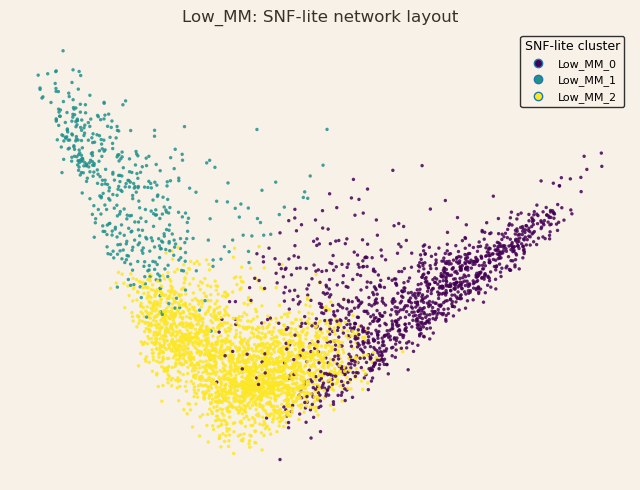

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_Low_MM.png

=== SNF network layout: Mid_MM ===


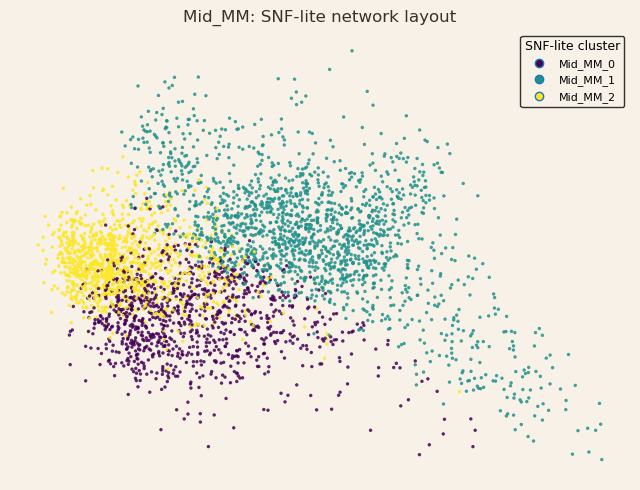

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_Mid_MM.png

=== SNF network layout: High_MM ===


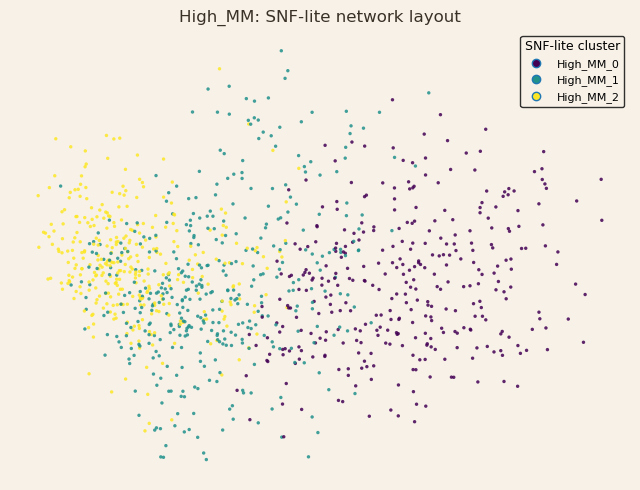

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_High_MM.png


In [55]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding

# ---------------------------------------------------------
# Assumes df, stratum_col and snf_col already exist
#   df: long dataframe with one row per patient
#   stratum_col: column with "Low_MM" / "Mid_MM" / "High_MM"
#   snf_col: column with SNF-lite labels (e.g. "label_snf")
# ---------------------------------------------------------

ROOT = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP")
FIG_DIR = ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# EDIT THESE PATHS to point to your fused affinity matrices
# (the order of rows/cols must match the patient order used when SNF was run)
FUSED_PATHS = {
    "Low_MM":  ROOT / "models" / 'snf_low'/ "snf_fused.npy",
    "Mid_MM":  ROOT / "models" / 'snf_mid' / "snf_fused.npy",
    "High_MM": ROOT / "models" / 'snf_high' / "snf_fused.npy",
}

PORTF_BG = "#f7f1e8"

for stratum, fused_path in FUSED_PATHS.items():
    if not fused_path.exists():
        print(f"[WARN] Fused matrix not found for {stratum}: {fused_path}")
        continue

    print(f"\n=== SNF network layout: {stratum} ===")
    W = np.load(fused_path)  # N x N fused similarity matrix

    # Get matching rows from df
    g = df[df[stratum_col] == stratum].copy()
    g = g.dropna(subset=[snf_col])
    labels = g[snf_col].astype(str).values

    if W.shape[0] != g.shape[0]:
        raise ValueError(
            f"Size mismatch for {stratum}: W has {W.shape[0]} nodes, "
            f"df has {g.shape[0]} rows. Make sure the ordering matches "
            "the patient order used in SNF."
        )

    # Spectral embedding of the precomputed affinity (graph layout)
    emb = SpectralEmbedding(
        n_components=2,
        affinity="precomputed",
        random_state=42,
    )
    coords = emb.fit_transform(W)  # (N x 2)

    # Map cluster labels to integer codes for colouring
    codes = pd.Categorical(labels).codes
    uniq = pd.Categorical(labels).categories

    plt.figure(figsize=(6.5, 5))
    ax = plt.gca()
    ax.set_facecolor(PORTF_BG)
    plt.gcf().patch.set_facecolor(PORTF_BG)

    sc = ax.scatter(
        coords[:, 0],
        coords[:, 1],
        c=codes,
        s=6,
        edgecolors="none",
        alpha=0.85,
    )

    # Build a custom legend with cluster names
    # Build a custom legend with cluster names
    handles = []
    for k, name in enumerate(uniq):
        handles.append(
            plt.Line2D(
                [], [], marker="o", linestyle="",
                markersize=6, markerfacecolor=sc.cmap(sc.norm(k)),
                label=str(name)
            )
        )

    leg = ax.legend(
        handles=handles,
        title="SNF-lite cluster",
        frameon=True,
        fontsize=8,
        title_fontsize=9,
        loc="best",
    )
    # Style legend frame to match portfolio
    frame = leg.get_frame()
    frame.set_facecolor(PORTF_BG)
    frame.set_edgecolor((0, 0, 0, 0.15))  # RGBA tuple in [0,1]


    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"{stratum}: SNF-lite network layout", fontsize=12, color="#3a3126")

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()

    out_path = FIG_DIR / f"snf_network_{stratum}.png"
    plt.savefig(out_path, dpi=300, facecolor=PORTF_BG, bbox_inches="tight")
    plt.show()

    print(f"[Saved] {out_path}")



=== SNF network layout: Low_MM ===


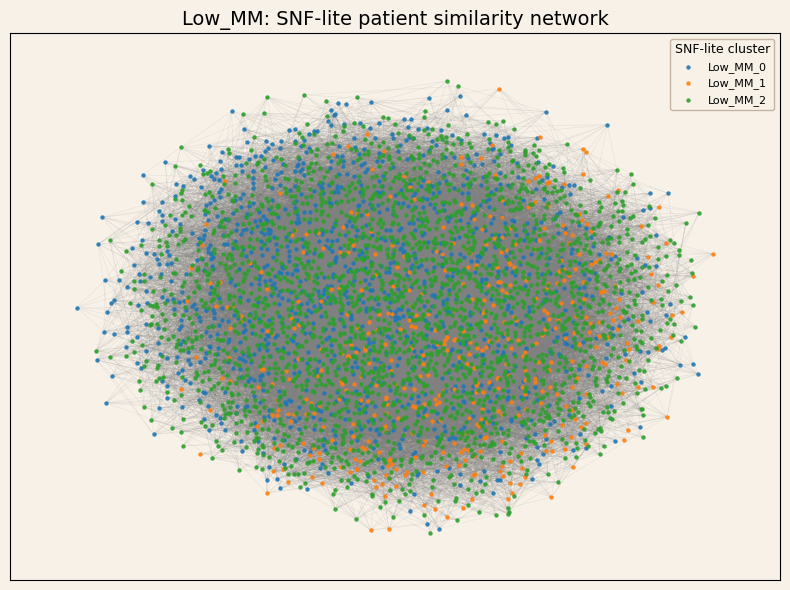

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_Low_MM.png

=== SNF network layout: Mid_MM ===


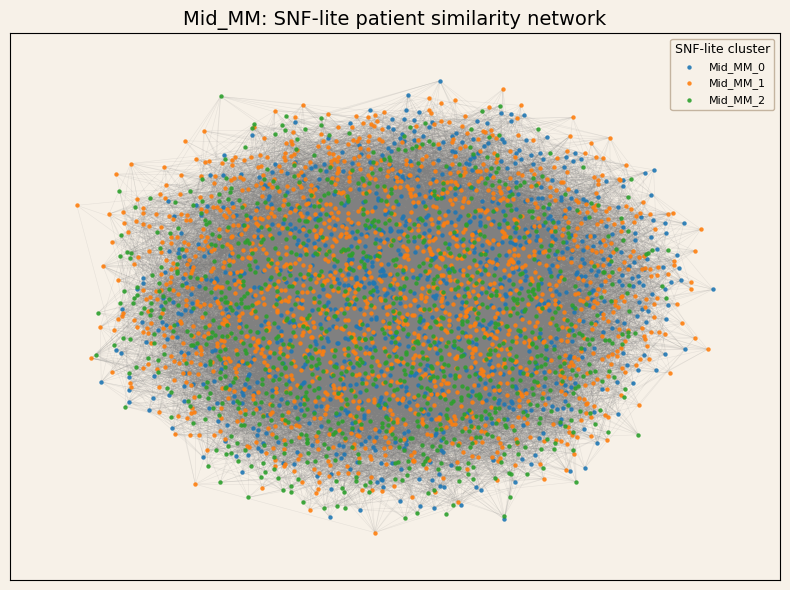

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_Mid_MM.png

=== SNF network layout: High_MM ===


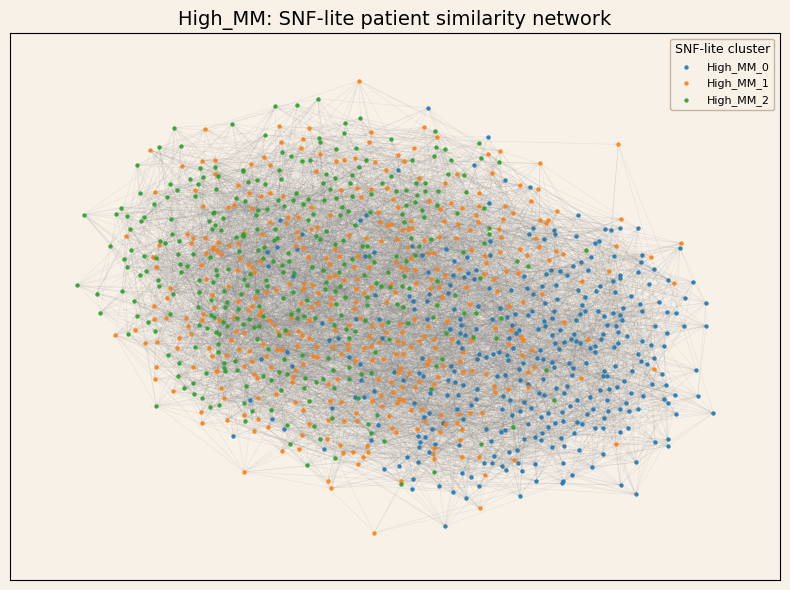

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_High_MM.png


In [56]:
# ============================================================
# SNF-lite patient similarity networks (with edges)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

PORTF_BG = "#f7f1e8"

ROOT = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP")
CLUS = ROOT / "data" / "02_clusters"

# SNF cluster assignments for all strata
snf_labels = pd.read_csv(CLUS / "snf_clusters_all.csv")

# Map each stratum to the fused matrix produced by the SNF-lite run
SNF_DIRS = {
    "Low_MM":  ROOT / "models" / "snf_low",
    "Mid_MM":  ROOT / "models" / "snf_mid",
    "High_MM": ROOT / "models" / "snf_high",
}

strata_order = ["Low_MM", "Mid_MM", "High_MM"]

# How dense should the network be?
K_NEIGH = 15   # top-K neighbours per node from the fused similarity matrix

for stratum in strata_order:
    print(f"\n=== SNF network layout: {stratum} ===")

    # --- 1. Labels for this stratum ---
    lab = (
        snf_labels[snf_labels["stratum"] == stratum]
        .reset_index(drop=True)
    )
    if lab.empty:
        print(f"[WARN] No SNF labels for {stratum}, skipping.")
        continue

    # We assume the fused matrix rows are in the same order as this CSV
    fused_path = SNF_DIRS[stratum] / "snf_fused.npy"
    if not fused_path.exists():
        print(f"[WARN] Fused matrix not found at {fused_path}, skipping.")
        continue

    W = np.load(fused_path)  # N x N fused similarity
    N = W.shape[0]
    assert N == len(lab), f"Shape mismatch: W has {N} rows, labels have {len(lab)}."

    # --- 2. Build a sparse K-NN graph from fused similarities ---
    G = nx.Graph()
    G.add_nodes_from(range(N))

    for i in range(N):
        # indices sorted descending by similarity (skip self)
        neigh_idx = np.argsort(W[i])[::-1][1:K_NEIGH+1]
        for j in neigh_idx:
            if i < j:  # undirected, avoid duplicates
                G.add_edge(i, j, weight=W[i, j])

    # --- 3. Layout with spring-layout on the graph ---
    pos = nx.spring_layout(
        G,
        k=0.12,          # spacing; tweak if things are too tight/loose
        iterations=100,
        seed=42,
        weight="weight",
    )

    # --- 4. Plot: edges + nodes coloured by SNF-lite cluster ---
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor(PORTF_BG)
    ax.set_facecolor(PORTF_BG)

    # Edges: light grey, low alpha
    nx.draw_networkx_edges(
        G,
        pos,
        ax=ax,
        edge_color="grey",
        alpha=0.15,
        width=0.4,
    )

    # Nodes: coloured by SNF cluster label
    clusters = lab["label"].astype("category")
    cat = clusters.cat.categories
    # simple palette
    palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
               "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

    handles = []
    for idx, name in enumerate(cat):
        nodes_idx = lab.index[clusters == name].tolist()
        color = palette[idx % len(palette)]

        sc = nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes_idx,
            node_size=10,
            node_color=color,
            linewidths=0,
            alpha=0.9,
            ax=ax,
            label=name,
        )
        handles.append(sc)

    ax.legend(
        handles=handles,
        title="SNF-lite cluster",
        frameon=True,
        facecolor=PORTF_BG,
        edgecolor="#b8a58e",
        fontsize=8,
        title_fontsize=9,
        loc="best",
    )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{stratum}: SNF-lite patient similarity network", fontsize=14)
    plt.tight_layout()

    out_path = ROOT / "reports" / "figures" / f"snf_network_{stratum}.png"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
    plt.show()

    print(f"[Saved] {out_path}")



=== SNF network layout (spectral): Low_MM ===


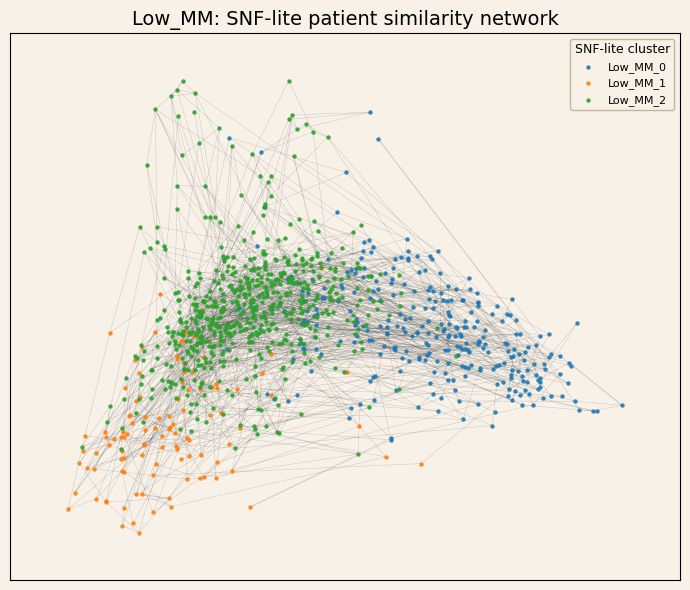

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_spectral_Low_MM.png

=== SNF network layout (spectral): Mid_MM ===


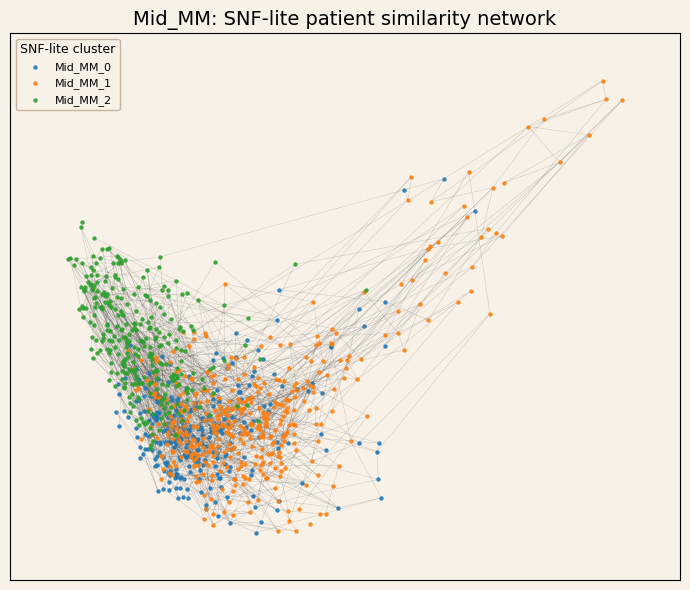

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_spectral_Mid_MM.png

=== SNF network layout (spectral): High_MM ===


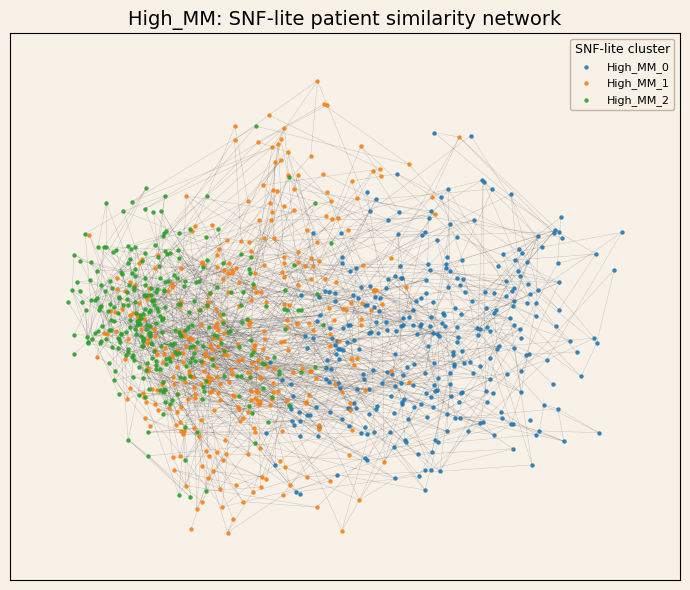

[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_spectral_High_MM.png


In [67]:
# ============================================================
# SNF-lite patient similarity networks (spectral embedding + sparse edges)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from sklearn.manifold import SpectralEmbedding

PORTF_BG = "#f7f1e8"

ROOT = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP")
CLUS = ROOT / "data" / "02_clusters"

snf_labels = pd.read_csv(CLUS / "snf_clusters_all.csv")

SNF_DIRS = {
    "Low_MM":  ROOT / "models" / "snf_low",
    "Mid_MM":  ROOT / "models" / "snf_mid",
    "High_MM": ROOT / "models" / "snf_high",
}

strata_order = ["Low_MM", "Mid_MM", "High_MM"]

# how dense & how big for plotting
K_NEIGH = 3          # edges per node
MAX_NODES_PLOT = 1000   # subsample for prettier figures

palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
           "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

for stratum in strata_order:
    print(f"\n=== SNF network layout (spectral): {stratum} ===")

    labs = snf_labels[snf_labels["stratum"] == stratum].reset_index(drop=True)
    if labs.empty:
        print(f"[WARN] No labels for {stratum}, skipping.")
        continue

    fused_path = SNF_DIRS[stratum] / "snf_fused.npy"
    if not fused_path.exists():
        print(f"[WARN] No fused matrix at {fused_path}, skipping.")
        continue

    W = np.load(fused_path)   # N x N fused similarity
    N = W.shape[0]
    assert N == len(labs), f"Row mismatch: W={N}, labels={len(labs)}"

    # -------- 1) Subsample nodes for plotting --------
    rng = np.random.default_rng(42)
    if N > MAX_NODES_PLOT:
        idx = rng.choice(N, size=MAX_NODES_PLOT, replace=False)
    else:
        idx = np.arange(N)

    W_sub = W[np.ix_(idx, idx)]
    labs_sub = labs.iloc[idx].reset_index(drop=True)
    N_sub = len(idx)

    # -------- 2) Spectral embedding of fused affinity --------
    emb = SpectralEmbedding(
        n_components=2,
        affinity="precomputed",
        random_state=42
    )
    XY = emb.fit_transform(W_sub)  # shape (N_sub, 2)

    pos = {i: XY[i] for i in range(N_sub)}

    # -------- 3) Build very sparse K-NN graph --------
    G = nx.Graph()
    G.add_nodes_from(range(N_sub))

    for i in range(N_sub):
        # top K neighbours by similarity (skip self)
        neigh = np.argsort(W_sub[i])[::-1][1:K_NEIGH+1]
        for j in neigh:
            if i < j:
                G.add_edge(i, j, weight=W_sub[i, j])

    # -------- 4) Plot: edges + coloured nodes --------
    fig, ax = plt.subplots(figsize=(7, 6))
    fig.patch.set_facecolor(PORTF_BG)
    ax.set_facecolor(PORTF_BG)

    # light, thin edges
    nx.draw_networkx_edges(
        G,
        pos,
        ax=ax,
        edge_color="#2D2D2D",
        alpha=0.25,
        width=0.3
    )

    clusters = labs_sub["label"].astype("category")
    cats = clusters.cat.categories

    handles = []
    for c_idx, name in enumerate(cats):
        node_ids = labs_sub.index[clusters == name].tolist()
        color = palette[c_idx % len(palette)]

        sc = nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=node_ids,
            node_size=10,
            node_color=color,
            linewidths=0,
            alpha=0.9,
            ax=ax,
            label=name,
        )
        handles.append(sc)

    ax.legend(
        handles=handles,
        title="SNF-lite cluster",
        frameon=True,
        facecolor=PORTF_BG,
        edgecolor="#b8a58e",
        fontsize=8,
        title_fontsize=9,
        loc="best",
    )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{stratum}: SNF-lite patient similarity network", fontsize=14)

    plt.tight_layout()

    out_path = ROOT / "reports" / "figures" / f"snf_network_spectral_{stratum}.png"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
    plt.show()

    print(f"[Saved] {out_path}")


In [70]:
# ============================================================
# SNF-lite patient similarity networks (Clean / No Borders)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from sklearn.manifold import SpectralEmbedding

# Background color matches the site
PORTF_BG = "#f7f1e8"

ROOT = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP")
CLUS = ROOT / "data" / "02_clusters"

snf_labels = pd.read_csv(CLUS / "snf_clusters_all.csv")

SNF_DIRS = {
    "Low_MM":  ROOT / "models" / "snf_low",
    "Mid_MM":  ROOT / "models" / "snf_mid",
    "High_MM": ROOT / "models" / "snf_high",
}

strata_order = ["Low_MM", "Mid_MM", "High_MM"]

# Plot settings
K_NEIGH = 3
MAX_NODES_PLOT = 1000

palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
           "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

for stratum in strata_order:
    print(f"\n=== Generating clean network for: {stratum} ===")

    labs = snf_labels[snf_labels["stratum"] == stratum].reset_index(drop=True)
    if labs.empty: continue

    fused_path = SNF_DIRS[stratum] / "snf_fused.npy"
    if not fused_path.exists(): continue

    W = np.load(fused_path)
    N = W.shape[0]

    # 1) Subsample
    rng = np.random.default_rng(42)
    if N > MAX_NODES_PLOT:
        idx = rng.choice(N, size=MAX_NODES_PLOT, replace=False)
    else:
        idx = np.arange(N)

    W_sub = W[np.ix_(idx, idx)]
    labs_sub = labs.iloc[idx].reset_index(drop=True)
    N_sub = len(idx)

    # 2) Spectral Embedding
    emb = SpectralEmbedding(n_components=2, affinity="precomputed", random_state=42)
    XY = emb.fit_transform(W_sub)
    pos = {i: XY[i] for i in range(N_sub)}

    # 3) Build Graph
    G = nx.Graph()
    G.add_nodes_from(range(N_sub))
    for i in range(N_sub):
        neigh = np.argsort(W_sub[i])[::-1][1:K_NEIGH+1]
        for j in neigh:
            if i < j:
                G.add_edge(i, j, weight=W_sub[i, j])

    # 4) Plot - The "Primo" Settings
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Ensure background is consistent
    fig.patch.set_facecolor(PORTF_BG)
    ax.set_facecolor(PORTF_BG)

    # Remove the box/border around the plot completely
    ax.axis('off')

    # Draw Edges
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edge_color="#2D2D2D", alpha=0.25, width=0.3
    )

    # Draw Nodes & Legend
    clusters = labs_sub["label"].astype("category")
    cats = clusters.cat.categories
    handles = []
    
    for c_idx, name in enumerate(cats):
        node_ids = labs_sub.index[clusters == name].tolist()
        color = palette[c_idx % len(palette)]
        sc = nx.draw_networkx_nodes(
            G, pos, nodelist=node_ids,
            node_size=12,  # Slightly larger for quality
            node_color=color,
            linewidths=0,
            alpha=0.9,
            ax=ax,
            label=name,
        )
        handles.append(sc)

    # Borderless Legend
    ax.legend(
        handles=handles,
        title="SNF-lite cluster",
        frameon=False,        # <--- No border box
        fontsize=8,
        title_fontsize=9,
        loc="best",
    )

    # Save Settings
    plt.tight_layout()
    
    # Note: Filename matches your HTML request
    out_path = ROOT / "reports" / "figures" / f"snf_network_{stratum}.png"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    
    plt.savefig(
        out_path, 
        dpi=300,                  # High Res
        bbox_inches="tight",      # Remove whitespace
        pad_inches=0.1, 
        facecolor=fig.get_facecolor()
    )
    plt.close() # Close memory
    print(f"[Saved] {out_path}")


=== Generating clean network for: Low_MM ===
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_Low_MM.png

=== Generating clean network for: Mid_MM ===
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_Mid_MM.png

=== Generating clean network for: High_MM ===
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/snf_network_High_MM.png
